<p style="font-size:36px;text-align:center"> <b>Personalized Cancer Diagnosis</b> </p>

<h1>1. Business Problem</h1>

Source : https://www.kaggle.com/c/msk-redefining-cancer-treatment/

<h2>1.1 Context </h2>

We understand that analyzing text represents a difficult challenge, but believe it or not is the current state of the art when it comes to interpretation of genetic variants.

The workflow is as follows

* A molecular pathologist selects a list of genetic variations of interest that he/she want to analyze
* The molecular pathologist searches for evidence in the medical literature that somehow are relevant to the genetic variations of interest
* Finally this molecular pathologist spends a huge amount of time analyzing the evidence related to each of the variations to classify them

Our goal here is to replace step 3 by a machine learning model. The molecular pathologist will still have to decide which variations are of interest, and also collect the relevant evidence for them. But the last step, which is also the most time consuming, will be fully automated.

<h2>1.2 Problem Statement </h2>

Classify the given genetic variations/mutations based on evidence from text-based clinical literature. 

<h2>1.3 Real world business constraints </h2>

* No low-latency requirement.
* Interpretability of the model is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation </h1>

<h2>2.1 Data </h2>

- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

There are nine different classes a genetic mutation can be classified into => Multi class classification problem

<h3>2.2.2. Performance Metric</h3>

* Multiclass logloss
* Confusion Matrix

<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>

* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h2>2.3. Train, CV and Test Datasets</h2>

We splitted the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively.

<h1>3. Exploratory Data Analysis</h1>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [22]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are :-
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 => the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [23]:
# note the seprator('||') in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [24]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replacing every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [25]:
#text preprocessing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for ID:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

There is no text description for ID: 1109
There is no text description for ID: 1277
There is no text description for ID: 1407
There is no text description for ID: 1639
There is no text description for ID: 2755
Time took for preprocessing the text : 32.27211629999988 seconds


In [26]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [27]:
#checking the rows where text description is not available
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


**Observation:** We got those ID's only which dosen't have a text description as seen earlier.

In [28]:
#replacing each NaN text with gene + variation
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']

In [29]:
#checking above replacement for ID = 1109
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>3.1.4. Train, Test and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [37]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# splitting the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2, random_state=42)
# splitting the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

**Note:** We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set 

In [38]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

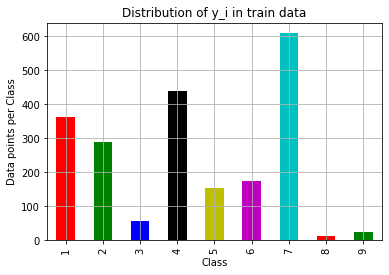

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


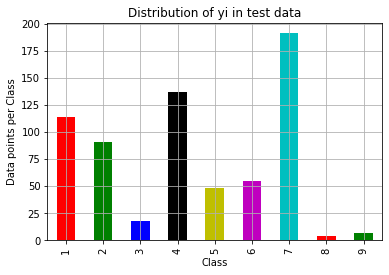

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


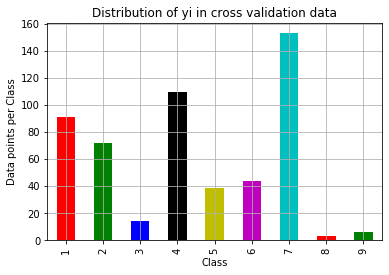

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [39]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']

train_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of y_i in train data')
plt.grid()
plt.show()

# the minus sign will give the output in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)

test_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)

cv_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


**Observations:**
* Data is imbalanced.
* Train, Test, and cross validation data have similar distribution of class labels (y_i's)

<h2>3.2 Prediction using a 'Random' Model</h2>

Since our performance metric, the multi-class logloss has no upper bound, we are creating a random model, so that the multi-class logloss for our actual model is less than that of the random model.

In [40]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    #confusion matrix
    C = confusion_matrix(test_y, predict_y)
    
    #precision matrix (column sum = 1)
    P = C/C.sum(axis=0)
    
    #recall matrix (row sum = 1)
    R = (((C.T)/(C.sum(axis=1))).T)
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(P, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(R, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [41]:
# Here, we need to generate 9 numbers and the sum of the numbers should be 1
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# We created an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

# We created an output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.5113274160802495
Log loss on Test Data using Random Model 2.403467600303703


**Confusion, Precision, and Recall Matrix for CV Data**

-------------------- Confusion matrix --------------------


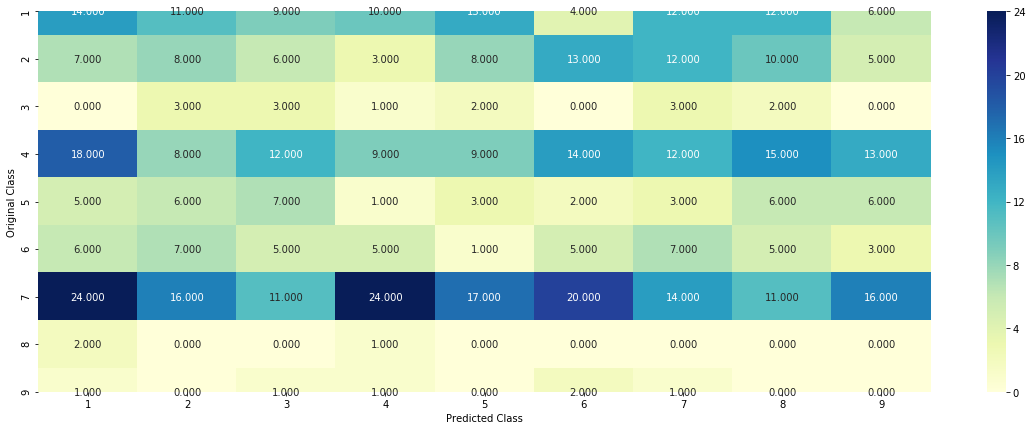

-------------------- Precision matrix (Columm Sum=1) --------------------


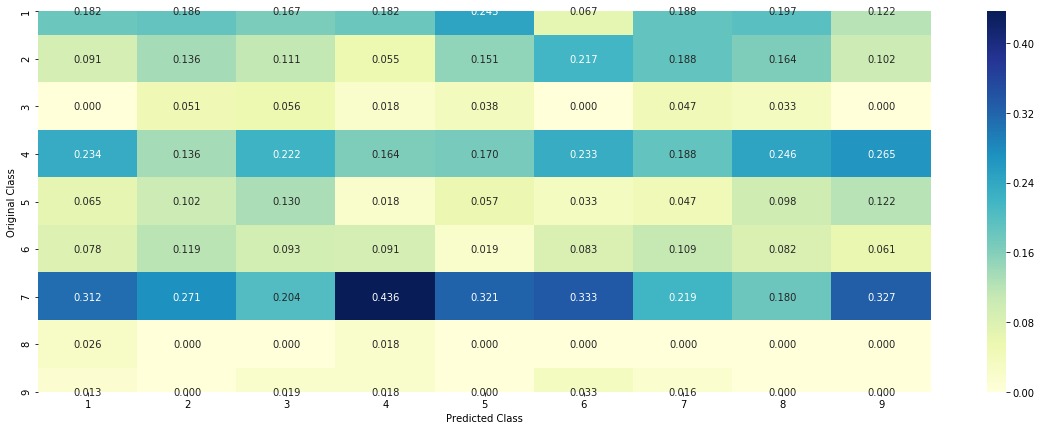

-------------------- Recall matrix (Row sum=1) --------------------


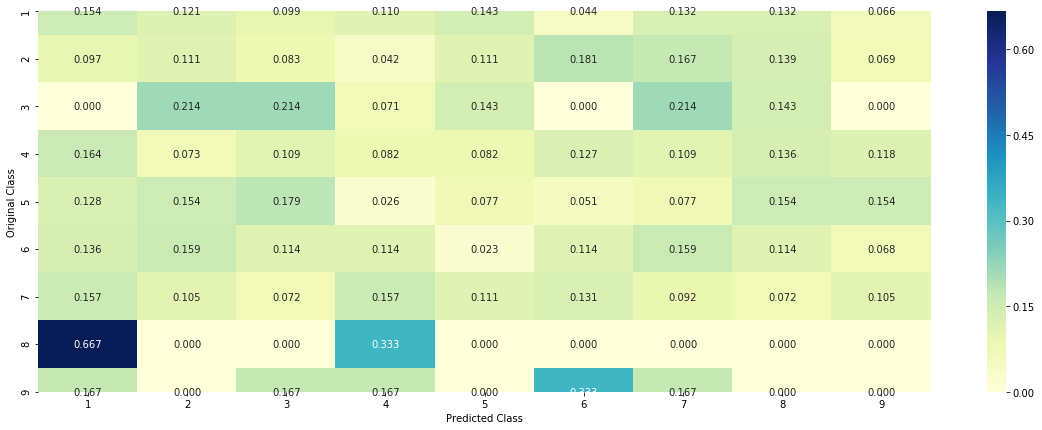

In [42]:
#Getting the index for which the probability is maximum
predicted_y_cv =np.argmax(cv_predicted_y, axis=1)

#The +1 is added because the class labels start from 1-9, and the index above is from 0-8
plot_confusion_matrix(y_cv, predicted_y_cv+1)

**Observations:** 
* Log-loss for our model should be fairly less than 2.5
* The plots give us a good visualization of the results for a random model

<h2>3.3 Univariate Analysis</h2>

<h3>3.2.1 Univariate Analysis on Gene Feature</h3>
'Gene' is a categorical variable.

In [43]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 236
BRCA1     154
TP53      104
EGFR       89
PTEN       88
BRCA2      83
KIT        63
BRAF       60
ALK        43
ERBB2      41
PDGFRA     41
Name: Gene, dtype: int64


There are 236 different categories of genes in the train data, and they are distibuted as follows:

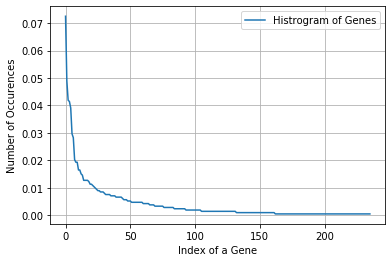

In [44]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show()

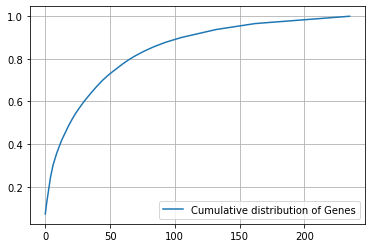

In [45]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

**Observation:** Nearly 70% of the genes belong to 50 classes among the total 236 classes.

**Featurizing the 'Gene' feature**

In [46]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [48]:
print("train_gene_feature_onehotCoding is a feature, converted using one-hot encoding method. The shape of the feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is a feature, converted using one-hot encoding method. The shape of the feature: (2124, 236)


In [47]:
# Generating Tfidf Vectors of Gene feature.
tfidf_gene_vectorizer = TfidfVectorizer()
train_gene_feature_tfidf = tfidf_gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_tfidf = tfidf_gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_tfidf = tfidf_gene_vectorizer.transform(cv_df['Gene'])

In [49]:
print("train_gene_feature_tfidf is a feature, converted tfidf vectorizer method. The shape of the feature:", train_gene_feature_tfidf.shape)

train_gene_feature_tfidf is a feature, converted tfidf vectorizer method. The shape of the feature: (2124, 236)


In [50]:
#function for getting the class probability vector of each datapoint required for response coding
def get_gv_feature(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class'] == k) & (train_df[feature] == i)]
            numerator = cls_cnt.shape[0]
            vec.append(((numerator + 10*alpha)/(denominator + 90*alpha)))
        gv_dict[i] = vec
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
            #if it's not present in train data, we are assigning equal probabilities for all the 9 classes
    return gv_fea

In [51]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [52]:
print("train_gene_feature_responseCoding is a feature, converted using respone coding method. The shape of the feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is a feature, converted using respone coding method. The shape of the feature: (2124, 9)


Now, to evaluate how good the 'Gene' feature is in predicting y_i, we have created a simple logistic regression model using only the 'Gene' feature (one-hot encoding), and computed it's logloss.

For values of alpha =  1e-05 The log loss is: 1.1897974843066177
For values of alpha =  0.0001 The log loss is: 1.1649615591529434
For values of alpha =  0.001 The log loss is: 1.1993973311277482
For values of alpha =  0.01 The log loss is: 1.3298530713185475
For values of alpha =  0.1 The log loss is: 1.4398064840944016
For values of alpha =  1 The log loss is: 1.4732418191604968


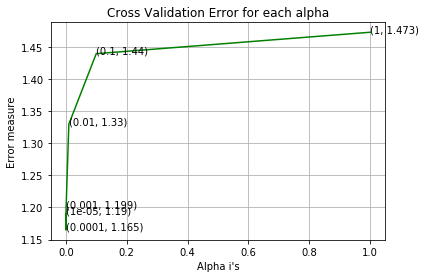

For values of best alpha =  0.0001 The train log loss is: 0.982290879087094
For values of best alpha =  0.0001 The cross validation log loss is: 1.1649615591529434
For values of best alpha =  0.0001 The test log loss is: 1.240228471543102


In [53]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**Observation:** 
* 'Gene' is an important feature as the log-loss is less than that of the random model.
* We can say that the 'Gene' feature is stable across Train, CV, and Test datasets, as the log-loss values are close to each other.

In [54]:
print("Q. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 642 out of 665 : 96.54135338345866
2. In cross validation data 523 out of  532 : 98.30827067669173


<h3>3.2.2 Univariate Analysis on Variation Feature</h3>
'Variation' is again a Categorical Variable

In [55]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 genes that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1923
Truncating_Mutations    66
Amplification           47
Deletion                42
Fusions                 23
Overexpression           4
T58I                     3
S222D                    2
K117N                    2
Y42C                     2
P34R                     2
Name: Variation, dtype: int64


There are 1923 different categories of variations in the train data, and they are distibuted as follows:

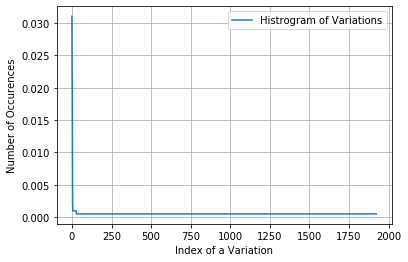

In [56]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show()

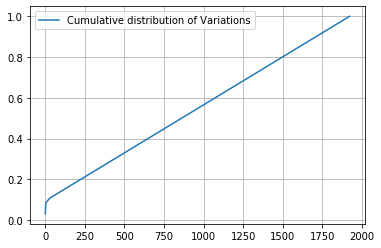

In [57]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

**Observation:** Since the CDF is a straight line, it means most variations occur once or maybe twice.

**Featurizing the 'Variation' feature**

In [115]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = gene_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = gene_vectorizer.transform(cv_df['Variation'])

In [116]:
print("train_variation_feature_onehotCoding is a feature, converted using one-hot encoding method. The shape of the feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotCoding is a feature, converted using one-hot encoding method. The shape of the feature: (2124, 1952)


In [120]:
# generating tfidf vectors of Variation feature.
tfidf_gene_vectorizer = TfidfVectorizer(max_features = 1000)
train_variation_feature_tfidf = tfidf_gene_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_tfidf = tfidf_gene_vectorizer.transform(test_df['Variation'])
cv_variation_feature_tfidf = tfidf_gene_vectorizer.transform(cv_df['Variation'])

In [121]:
print("train_variation_feature_tfidf is a feature, converted using tfidf vectorizer method. The shape of the feature:", train_variation_feature_tfidf.shape)

train_variation_feature_tfidf is a feature, converted using tfidf vectorizer method. The shape of the feature: (2124, 1000)


In [119]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [63]:
print("train_variation_feature_responseCoding is a feature, converted using respone coding method. The shape of the feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a feature, converted using respone coding method. The shape of the feature: (2124, 9)


Now, to evaluate how good the 'Variation' feature is in predicting y_i, we have created a simple logistic regression model using only the 'Variation' feature (one-hot encoding), and computed it's logloss.

For values of alpha =  1e-05 The log loss is: 1.7064839179831701
For values of alpha =  0.0001 The log loss is: 1.6997323424727564
For values of alpha =  0.001 The log loss is: 1.700215754040087
For values of alpha =  0.01 The log loss is: 1.7044768447535124
For values of alpha =  0.1 The log loss is: 1.7166940699499413
For values of alpha =  1 The log loss is: 1.7184643130199129


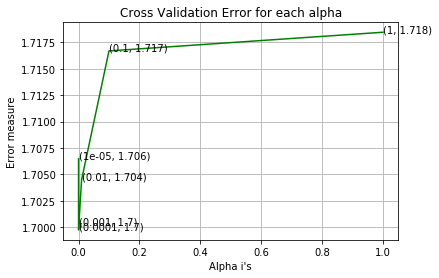

For values of best alpha =  0.0001 The train log loss is: 0.691518814366477
For values of best alpha =  0.0001 The cross validation log loss is: 1.6997323424727564
For values of best alpha =  0.0001 The test log loss is: 1.7230993136874655


In [64]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**Observation:** 
* 'Variation' is an important feature as the log-loss is less than that of the random model.
* 'Variation' feature is more unstable than 'Gene' feature as the log-loss values for CV and Test are significantly higher.
* Also 'Gene' feature is more important than 'Variation'.

In [114]:
print("Q. How many data points in Test and CV datasets are covered by the ", unique_variations.shape[0], " variations in train dataset?")

test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the  1923  variations in train dataset?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 53 out of  532 : 9.962406015037594


**Observation:** The above analysis shows that the 'Variation' feature is highly unstable stable across Train, CV, and Test datasets.

<h3>3.2.3 Univariate Analysis on Text Feature</h3>

In [66]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every column and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53295


In [67]:
#returns a dictionary with distinct words as keys, and their count as values in a text
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int) #to avoid KeyError
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [69]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    # getting all the rows belonging to the ith class
    cls_text = train_df[train_df['Class']==i]
    # building a word dict based on the words in ith class and appending it to dict_list
    dict_list.append(extract_dictionary_paddle(cls_text))

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

In [70]:
import math
#response-encoding of text data using Naive Bayes approach
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                #Adding all the log values
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            #raising the final value to the power of 'e'
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [71]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [72]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [73]:
# normalizing train text feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# normalizing test text feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# normalizing cv text feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [123]:
#creating tfidf vectors with max features 1000
tfidf_text_vectorizer = TfidfVectorizer(max_features = 1000)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
# normalizing train text feature
train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
# normalizing test text feature
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])
# normalizing cv text feature
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=0)

In [124]:
#we are only going to use this bigram approach for Logistic Regression, because it can handle higher dimensions

# building a CountVectorizer with all the words that occured minimum 3 times in train data with both unigrams and bigrams
text_vectorizer_2 = CountVectorizer(min_df=3, ngram_range=(1,2))
train_text_feature_onehotCoding_2 = text_vectorizer_2.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_2= text_vectorizer_2.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every column and returns (1*number of features) vector
train_text_fea_counts_2 = train_text_feature_onehotCoding_2.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_2 = dict(zip(list(train_text_features_2),train_text_fea_counts_2))


print("Total number of unique words in train data :", len(train_text_features_2))

Total number of unique words in train data : 775926


In [125]:
# normalizing train text feature
train_text_feature_onehotCoding_2 = normalize(train_text_feature_onehotCoding_2, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_2 = text_vectorizer_2.transform(test_df['TEXT'])
# normalizing test text feature
test_text_feature_onehotCoding_2 = normalize(test_text_feature_onehotCoding_2, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_2 = text_vectorizer_2.transform(cv_df['TEXT'])
# normalizing cv text feature
cv_text_feature_onehotCoding_2 = normalize(cv_text_feature_onehotCoding_2, axis=0)

In [74]:
#sorting the feature dictionary according to it's values
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [75]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5561, 4: 3532, 6: 2615, 5: 2501, 7: 2262, 8: 2001, 9: 1840, 10: 1376, 12: 1146, 13: 1122, 11: 1100, 15: 960, 14: 906, 16: 895, 18: 752, 21: 686, 17: 626, 20: 596, 19: 532, 22: 493, 24: 467, 30: 393, 23: 379, 25: 368, 27: 348, 28: 341, 41: 337, 26: 318, 32: 315, 36: 307, 31: 303, 33: 284, 47: 279, 34: 268, 29: 266, 35: 247, 37: 212, 40: 210, 42: 203, 45: 196, 48: 185, 39: 184, 44: 183, 43: 182, 50: 180, 38: 166, 54: 162, 55: 156, 51: 154, 46: 154, 52: 151, 49: 149, 56: 139, 60: 135, 53: 132, 66: 130, 61: 126, 58: 126, 64: 124, 63: 118, 57: 110, 67: 108, 59: 107, 62: 105, 72: 104, 74: 103, 68: 102, 84: 98, 70: 97, 65: 95, 80: 91, 73: 90, 69: 90, 77: 83, 94: 79, 88: 79, 83: 77, 82: 74, 71: 74, 86: 73, 81: 73, 76: 72, 91: 71, 85: 71, 75: 71, 100: 70, 90: 69, 78: 65, 99: 64, 105: 62, 92: 62, 87: 62, 95: 61, 126: 59, 96: 59, 93: 59, 98: 58, 111: 57, 97: 56, 101: 53, 89: 53, 79: 53, 135: 52, 109: 52, 110: 50, 106: 50, 125: 49, 107: 49, 102: 49, 103: 47, 140: 46, 108: 46, 129: 44, 

For values of alpha =  1e-05 The log loss is: 1.2914640556230466
For values of alpha =  0.0001 The log loss is: 1.1625015782057182
For values of alpha =  0.001 The log loss is: 1.1526935974107262
For values of alpha =  0.01 The log loss is: 1.2158661038549101
For values of alpha =  0.1 The log loss is: 1.4386728816178431
For values of alpha =  1 The log loss is: 1.636537127705796


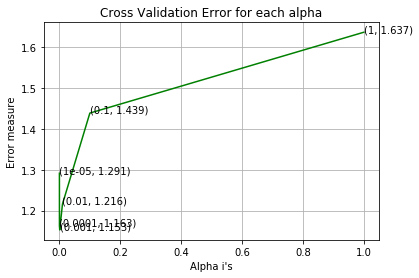

For values of best alpha =  0.001 The train log loss is: 0.639412810414066
For values of best alpha =  0.001 The cross validation log loss is: 1.1526935974107262
For values of best alpha =  0.001 The test log loss is: 1.3122220272900456


In [76]:
# Training a Logistic regression+Calibration model using text features whicha are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


**Observation:** 
* 'Text' is an important feature as the log-loss is less than that of the random model.
* The 'Text' feature semms to be stable across Train, CV, and Test datasets.

In [77]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of Test data appeared in Train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation data appeared in Train data")

96.282 % of word of Test data appeared in Train data
97.561 % of word of Cross Validation data appeared in Train data


<h1>4. Machine Learning Models</h1>

In [78]:
#Misc. function for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y)), "among total points: ",test_y.shape[0])
    print("Percentage of misclassified points : ", (np.count_nonzero((pred_y- test_y))/test_y.shape[0])*100)
    plot_confusion_matrix(test_y, pred_y)

In [135]:
#Stacking all the three features

#one-hot encoding features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

#response coding features
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

#tfidf features
train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_variation_feature_tfidf))

train_x_tfidf = hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()

#one-hot encoding features with bigram
train_x_onehotCoding_2 = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2)).tocsr()
test_x_onehotCoding_2 = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2)).tocsr()
cv_x_onehotCoding_2 = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2)).tocsr()

In [80]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55483)
(number of data points * number of features) in test data =  (665, 55483)
(number of data points * number of features) in cross validation data = (532, 55483)


In [81]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [136]:
print(" TFIDF encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf.shape)

 TFIDF encoding features :
(number of data points * number of features) in train data =  (2124, 2236)
(number of data points * number of features) in test data =  (665, 2236)
(number of data points * number of features) in cross validation data = (532, 2236)


In [137]:
print("One hot encoding features with bigrams :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding_2.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding_2.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding_2.shape)

One hot encoding features with bigrams :
(number of data points * number of features) in train data =  (2124, 778114)
(number of data points * number of features) in test data =  (665, 778114)
(number of data points * number of features) in cross validation data = (532, 778114)


**Observation:**
* We get high dimensional data with one-hot encoding => works well with Logistic Regression, Linear SVM, etc. simple models.
* We get low dimensional data with response coding => works well with Decision Trees, KNN, Random Forest, etc. complex models.
* Tfidf encoding => should work with all the models.
* one-hot encoding with bigrams => dimension is huge; going to try Logistic Regression only.

<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes - (one-hot encoding)</h3>

Naive Bayes typically works well with text data.

<h4>4.1.1.1. Hyper parameter tuning</h4>

For values of alpha =  1e-05 The log loss is: 1.2807541569914733
For values of alpha =  0.0001 The log loss is: 1.2786647519191472
For values of alpha =  0.001 The log loss is: 1.2633901383311126
For values of alpha =  0.1 The log loss is: 1.2577638557132667
For values of alpha =  1 The log loss is: 1.2662806431204474
For values of alpha =  10 The log loss is: 1.3625148230085435
For values of alpha =  100 The log loss is: 1.3729468880258022
For values of alpha =  1000 The log loss is: 1.3216104270952407


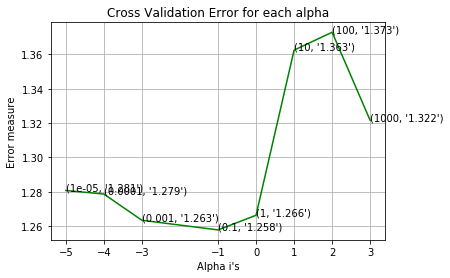

For values of best alpha =  0.1 The train log loss is: 0.8484447180268438
For values of best alpha =  0.1 The cross validation log loss is: 1.2577638557132667
For values of best alpha =  0.1 The test log loss is: 1.3645239354177918


In [165]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.3645239354177918
Number of mis-classified points : 286 among total points:  665
Percentage of misclassified points :  43.007518796992485
-------------------- Confusion matrix --------------------


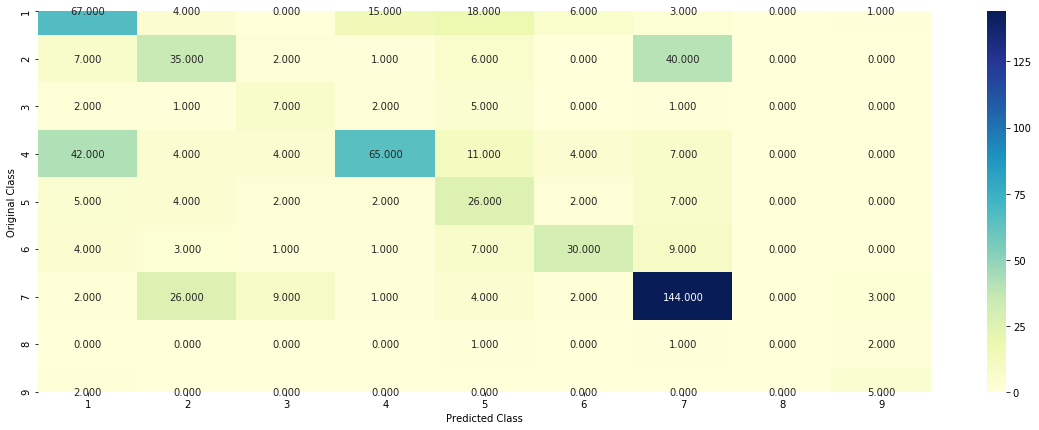

-------------------- Precision matrix (Columm Sum=1) --------------------


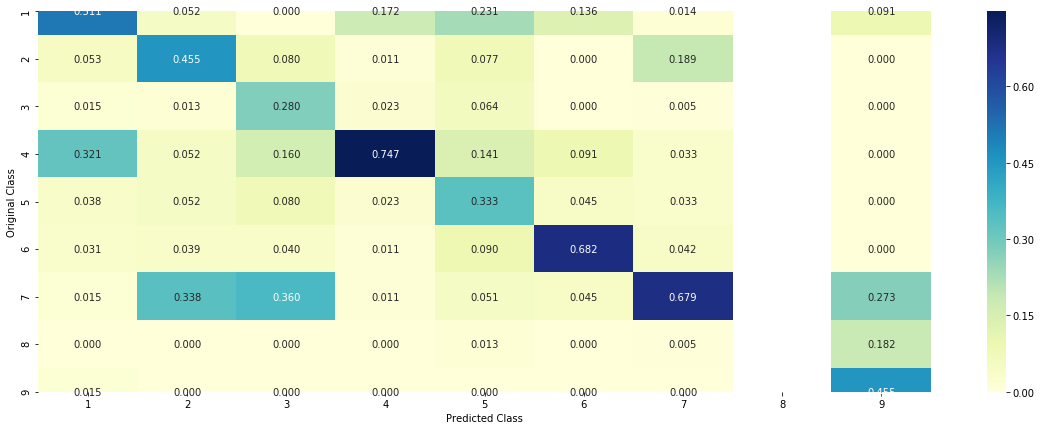

-------------------- Recall matrix (Row sum=1) --------------------


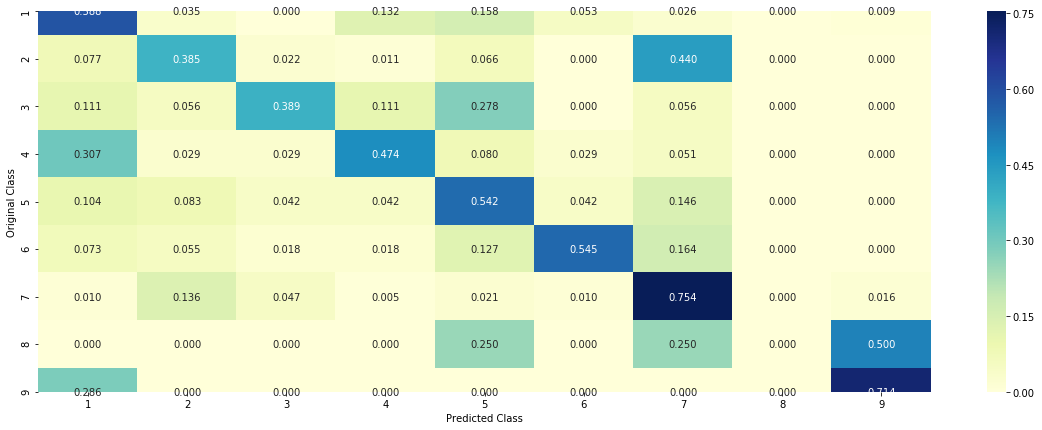

In [166]:
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

**Observation:** There is some confusion between classes 1,2,4, and 7 as they are the majority classes.

Now, we will find the feature importance to ensure interpretability of the model.

In [167]:
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene.strip() else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var.strip() else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in the query point")

<h4>4.1.1.3. Feature Importance, Correctly classified point</h4>

In [170]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0784 0.0723 0.0131 0.1025 0.0317 0.561  0.1321 0.0045 0.0044]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in the query point


<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [171]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 9
Predicted Class Probabilities: [[0.0965 0.0857 0.0153 0.1249 0.039  0.0479 0.1607 0.0411 0.3887]]
Actual Class : 7
--------------------------------------------------
461 Text feature [misregulated] present in test data point [True]
Out of the top  500  features  1 are present in the query point


<h3>4.1.2. Naive Bayes - (tfidf encoding)</h3>

<h4>4.1.2.1. Hyper parameter tuning</h4>

For values of alpha =  1e-05 The log loss is: 1.144457062743433
For values of alpha =  0.0001 The log loss is: 1.1443449455907493
For values of alpha =  0.001 The log loss is: 1.1422743655622534
For values of alpha =  0.1 The log loss is: 1.1871711316056055
For values of alpha =  1 The log loss is: 1.2199752135454018
For values of alpha =  10 The log loss is: 1.367490073190052
For values of alpha =  100 The log loss is: 1.3474990772754787
For values of alpha =  1000 The log loss is: 1.3452522582100526


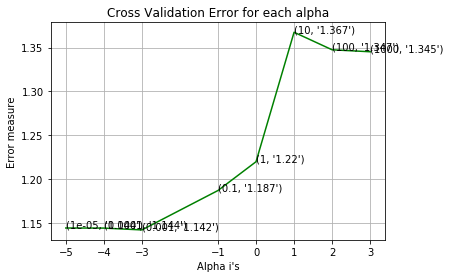

For values of best alpha =  0.001 The train log loss is: 0.7102383523922557
For values of best alpha =  0.001 The cross validation log loss is: 1.1422743655622534
For values of best alpha =  0.001 The test log loss is: 1.272577643113673


In [172]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)


predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.1.2.2. Testing the model with best hyper paramters</h4>

Log loss : 1.272577643113673
Number of mis-classified points : 276 among total points:  665
Percentage of misclassified points :  41.50375939849624
-------------------- Confusion matrix --------------------


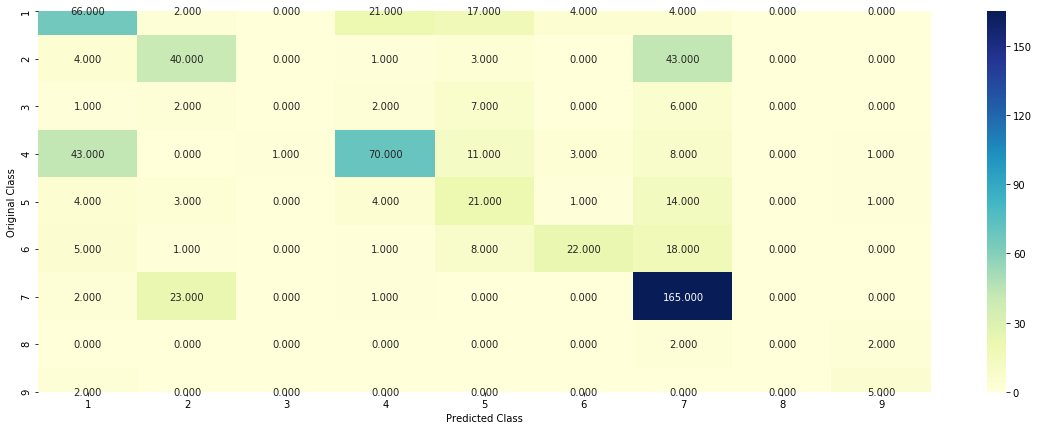

-------------------- Precision matrix (Columm Sum=1) --------------------


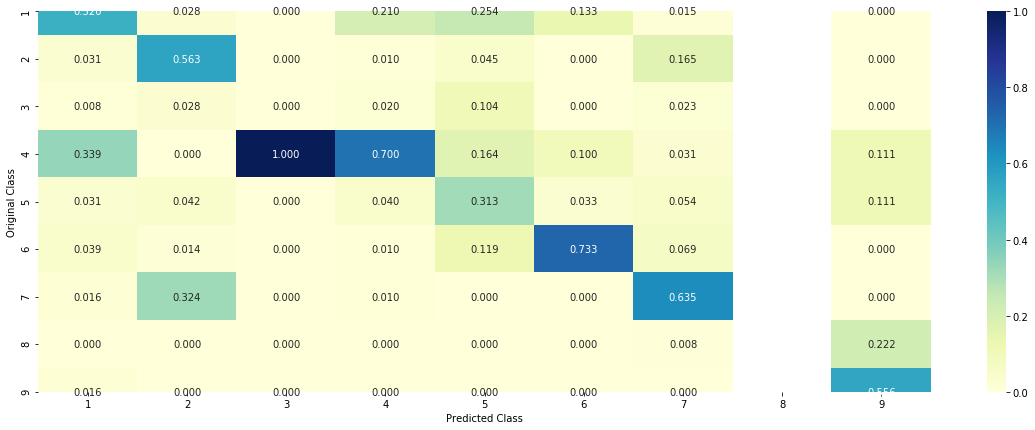

-------------------- Recall matrix (Row sum=1) --------------------


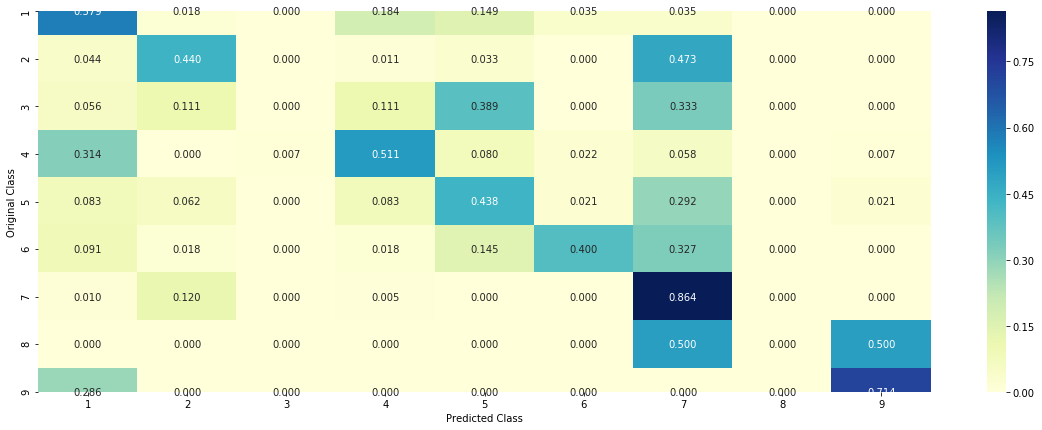

In [173]:
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

Now, we will find the feature importance to ensure interpretability of the model.

In [174]:
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names_tfidf(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer(max_features=1000)
    text_count_vec = TfidfVectorizer(min_df=3, max_features=1000)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene.strip() else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var.strip() else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in the query point")

<h4>4.1.2.3. Feature Importance, Correctly classified point</h4>

In [175]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0586 0.0509 0.0162 0.0785 0.0414 0.6707 0.0756 0.0039 0.0041]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in the query point


<h4>4.1.2.4. Feature Importance, Incorrectly classified point</h4>

In [176]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3781 0.092  0.0234 0.2131 0.0524 0.056  0.1601 0.0084 0.0166]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in the query point


<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. KNN - Using response encoding </h3>

<h4>4.2.1.1. Hyper parameter tuning</h4>

For values of alpha =  5 The log loss is: 1.049149622750796
For values of alpha =  11 The log loss is: 1.0250864830704727
For values of alpha =  15 The log loss is: 1.0409705544042105
For values of alpha =  21 The log loss is: 1.0585552158371785
For values of alpha =  31 The log loss is: 1.074351144882226
For values of alpha =  41 The log loss is: 1.0916688210991774
For values of alpha =  51 The log loss is: 1.093623408791066
For values of alpha =  99 The log loss is: 1.1314945896463522


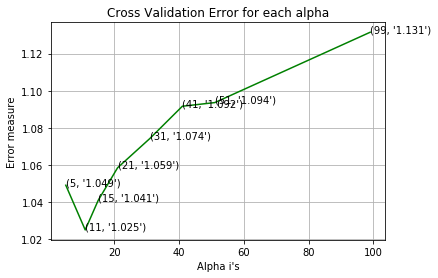

For values of best alpha =  11 The train log loss is: 0.590869654975414
For values of best alpha =  11 The cross validation log loss is: 1.0250864830704727
For values of best alpha =  11 The test log loss is: 1.1869827428055426


In [177]:
#Here alpha is the number of neighbours
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>4.2.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.1869827428055426
Number of mis-classified points : 280 among total points:  665
Percentage of misclassified points :  42.10526315789473
-------------------- Confusion matrix --------------------


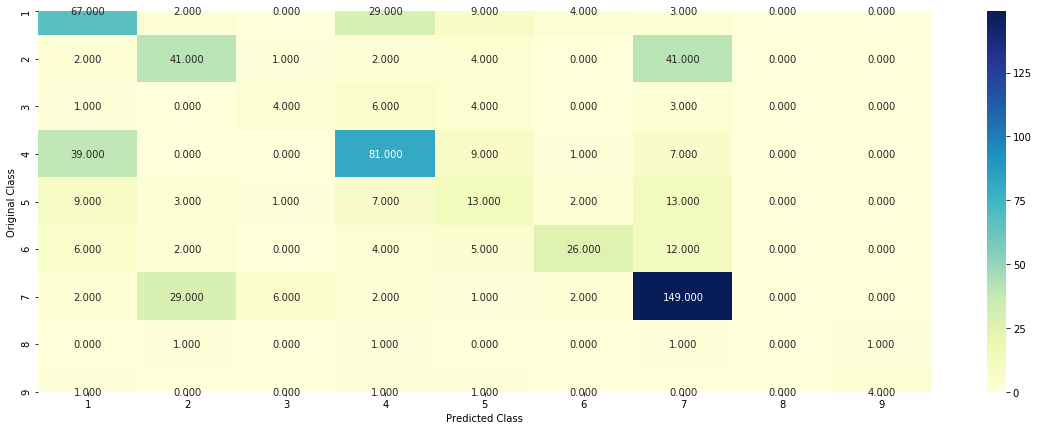

-------------------- Precision matrix (Columm Sum=1) --------------------


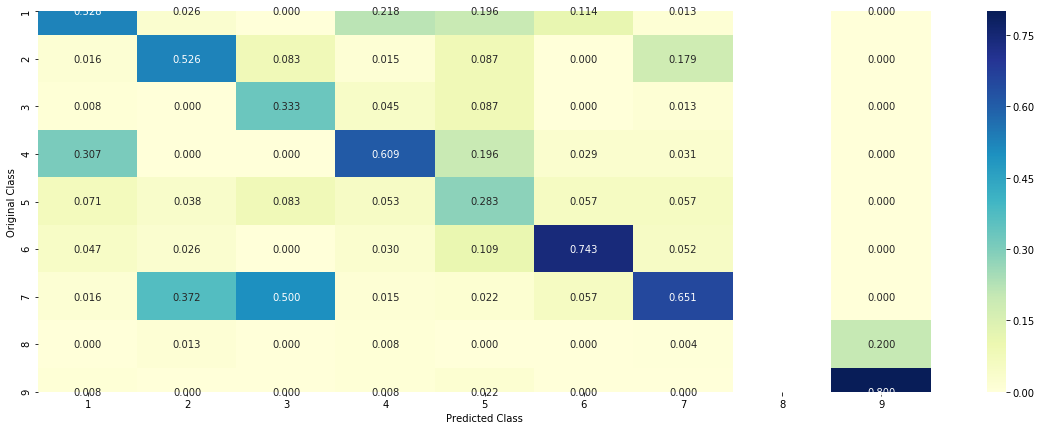

-------------------- Recall matrix (Row sum=1) --------------------


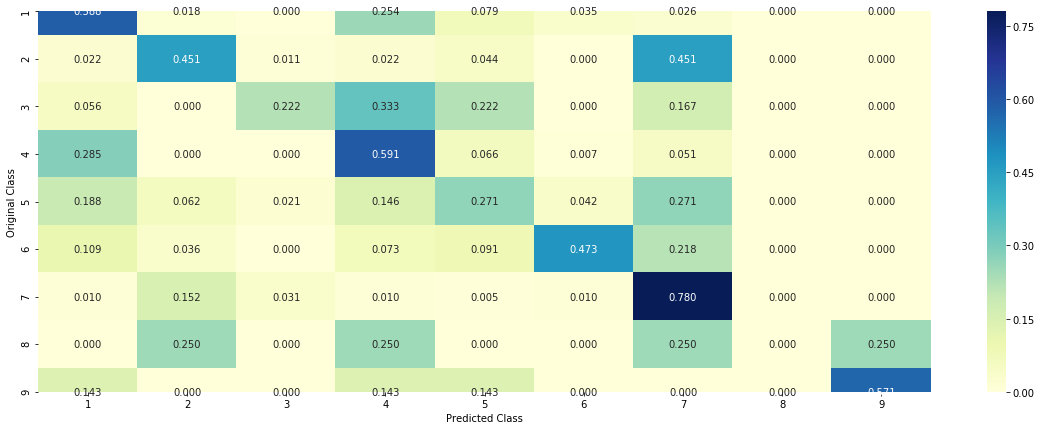

In [181]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, test_x_responseCoding, test_y, clf)

<h4>4.2.1.3.Sample Query point -1</h4>

In [182]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 2
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [4 4 4 8 1 8 4 7 2 2 2]
Fequency of nearest points : Counter({4: 4, 2: 3, 8: 2, 1: 1, 7: 1})


<h4>4.2.1.4.Sample Query point -2</h4>

In [183]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
The  11  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 7 6 1 1 1]
Fequency of nearest points : Counter({1: 9, 7: 1, 6: 1})


**Observation:** We can't get clear feature importance, hence KNN model is not interpretable.

<h2>4.3. Logistic Regression</h2>

We consider one-hot encoding feature as LR easily works for high dimensional data.

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Using one-hot encoding features</h4>

<h5>4.3.1.1.1. Hyper paramter tuning</h5>

For values of alpha =  1e-06 The log loss is: 1.3138329411023488
For values of alpha =  1e-05 The log loss is: 1.3034266977856461
For values of alpha =  0.0001 The log loss is: 1.0952337874972717
For values of alpha =  0.001 The log loss is: 1.0558030847817585
For values of alpha =  0.01 The log loss is: 1.1049128793055607
For values of alpha =  0.1 The log loss is: 1.4747749225717783
For values of alpha =  1 The log loss is: 1.7184763011749165
For values of alpha =  10 The log loss is: 1.7484305881095894
For values of alpha =  100 The log loss is: 1.7514393459546238


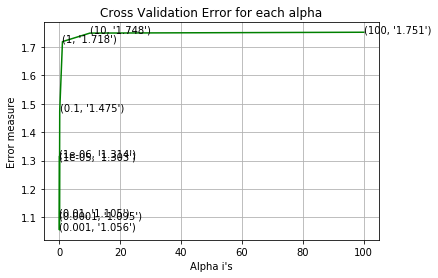

For values of best alpha =  0.001 The train log loss is: 0.5142642103629723
For values of best alpha =  0.001 The cross validation log loss is: 1.0558030847817585
For values of best alpha =  0.001 The test log loss is: 1.2566191559980855


In [184]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.1.1.2. Testing the model with best hyper paramters</h5>

Log loss : 1.2566191559980855
Number of mis-classified points : 247 among total points:  665
Percentage of misclassified points :  37.142857142857146
-------------------- Confusion matrix --------------------


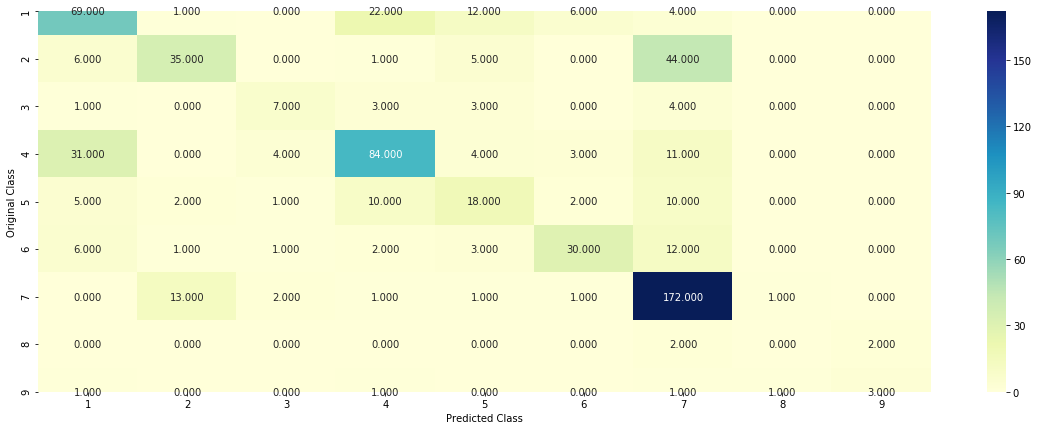

-------------------- Precision matrix (Columm Sum=1) --------------------


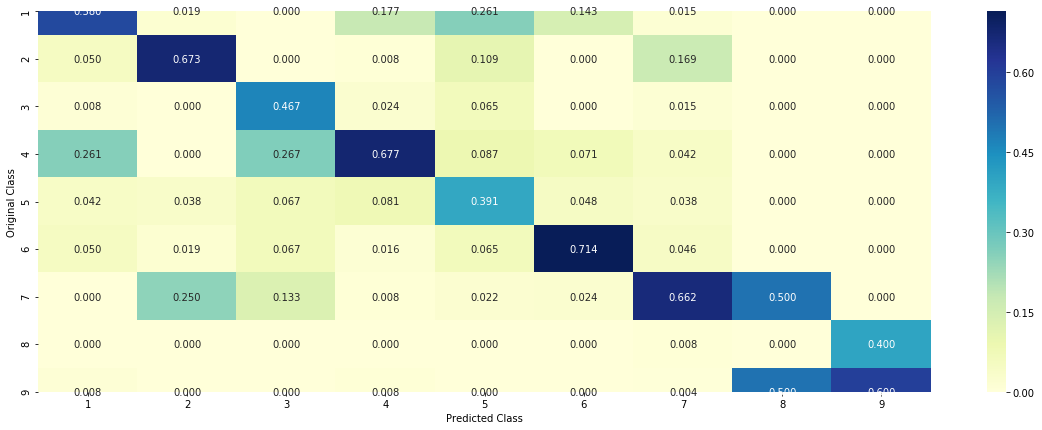

-------------------- Recall matrix (Row sum=1) --------------------


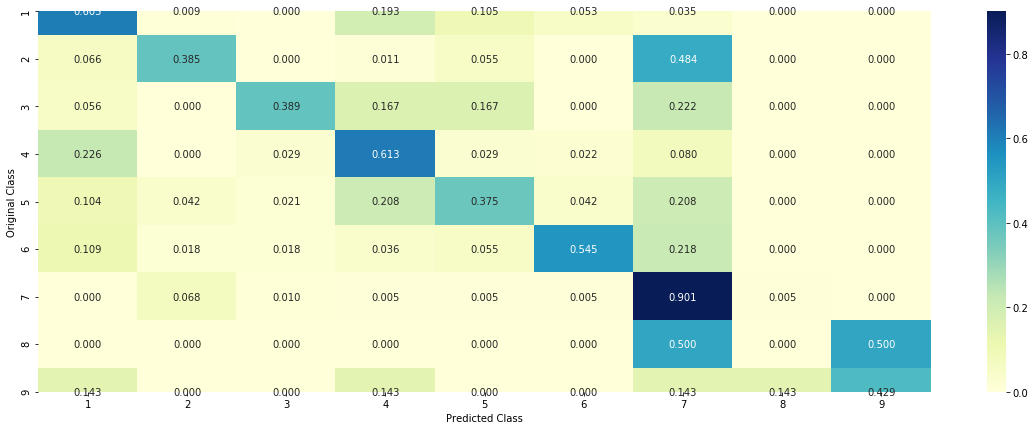

In [185]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

<h5>4.3.1.1.3. Feature Importance - Correctly Classified point</h5>

In [186]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1449 0.1785 0.0101 0.1551 0.03   0.0669 0.3722 0.0137 0.0286]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in the query point


<h5>4.3.1.1.4. Feature Importance - Incorrectly Classified point</h5>

In [187]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.646e-01 6.500e-03 7.000e-04 2.700e-03 2.200e-03 2.500e-03 1.390e-02
  5.700e-03 1.000e-03]]
Actual Class : 1
--------------------------------------------------
229 Text feature [kinase] present in test data point [True]
Out of the top  500  features  1 are present in the query point


<h4>4.3.1.2. Using TFIDF features</h4>

<h5>4.3.1.2.1. Hyper paramter tuning</h5>

For values of alpha =  1e-06 The log loss is: 1.1261570117037796
For values of alpha =  1e-05 The log loss is: 0.998744403535194
For values of alpha =  0.0001 The log loss is: 0.9289301430025526
For values of alpha =  0.001 The log loss is: 0.958144217693101
For values of alpha =  0.01 The log loss is: 1.1928518478756813
For values of alpha =  0.1 The log loss is: 1.6152541239362979
For values of alpha =  1 The log loss is: 1.7716488437075504
For values of alpha =  10 The log loss is: 1.7908662699918723
For values of alpha =  100 The log loss is: 1.7931503895321765


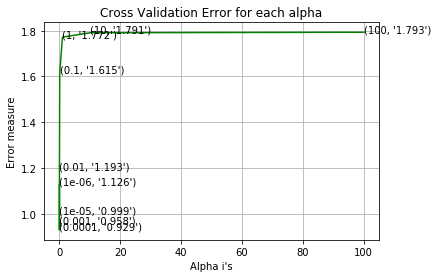

For values of best alpha =  0.0001 The train log loss is: 0.5233736351332338
For values of best alpha =  0.0001 The cross validation log loss is: 0.9289301430025526
For values of best alpha =  0.0001 The test log loss is: 1.1194986726081553


In [188]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.1.2.2. Testing the model with best hyper paramters</h5>

Log loss : 1.1194986726081553
Number of mis-classified points : 253 among total points:  665
Percentage of misclassified points :  38.045112781954884
-------------------- Confusion matrix --------------------


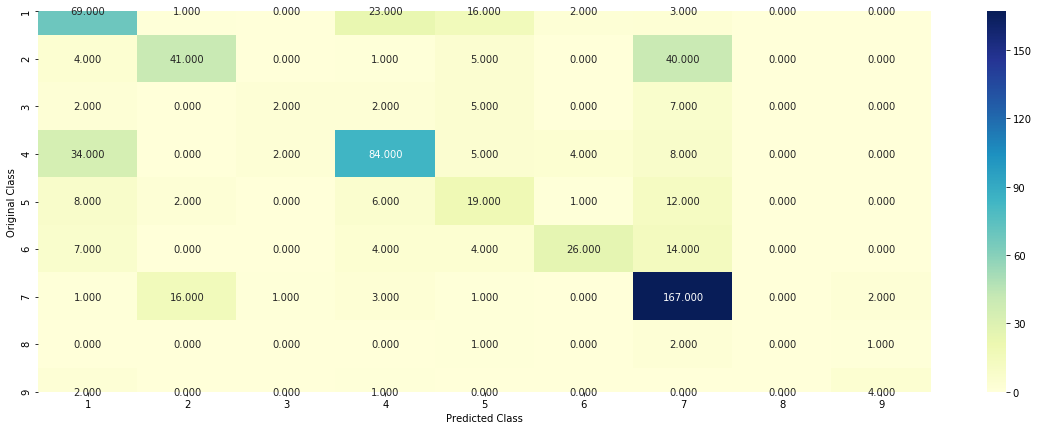

-------------------- Precision matrix (Columm Sum=1) --------------------


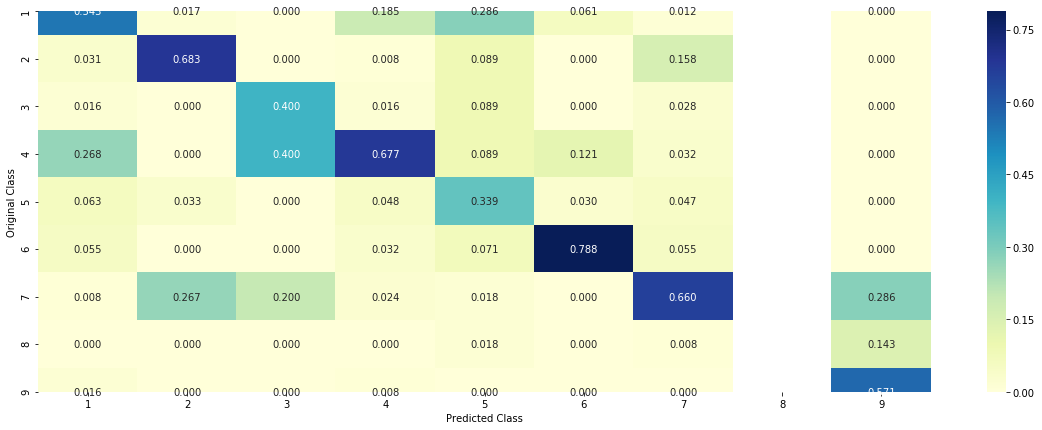

-------------------- Recall matrix (Row sum=1) --------------------


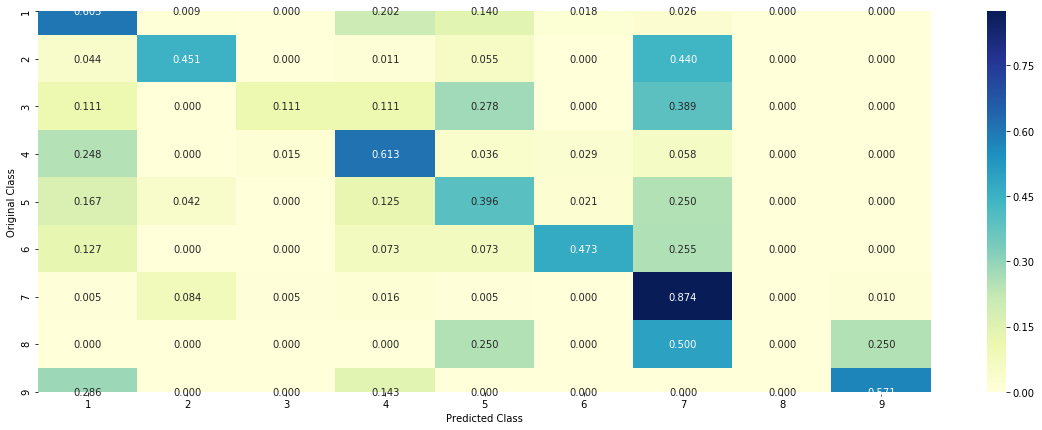

In [189]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

<h5>4.3.1.2.3. Feature Importance - Incorrectly Classified point</h5>

In [190]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1701 0.098  0.0008 0.3218 0.0458 0.062  0.2695 0.0275 0.0045]]
Actual Class : 7
--------------------------------------------------
82 Text feature [mm] present in test data point [True]
104 Text feature [deletion] present in test data point [True]
105 Text feature [independent] present in test data point [True]
107 Text feature [greater] present in test data point [True]
114 Text feature [value] present in test data point [True]
117 Text feature [forms] present in test data point [True]
151 Text feature [tumorigenesis] present in test data point [True]
158 Text feature [grade] present in test data point [True]
160 Text feature [values] present in test data point [True]
171 Text feature [suggesting] present in test data point [True]
172 Text feature [harboring] present in test data point [True]
173 Text feature [ref] present in test data point [True]
178 Text feature [resulting] present in test data point [True]
196 Text feature [pa

<h5>4.3.1.2.4. Feature Importance - Correctly Classified point</h5>

In [191]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.9139 0.012  0.0028 0.0216 0.0035 0.0184 0.0236 0.0033 0.001 ]]
Actual Class : 1
--------------------------------------------------
24 Text feature [surface] present in test data point [True]
25 Text feature [repeats] present in test data point [True]
38 Text feature [panel] present in test data point [True]
56 Text feature [hydrophobic] present in test data point [True]
58 Text feature [mm] present in test data point [True]
92 Text feature [blue] present in test data point [True]
96 Text feature [occur] present in test data point [True]
100 Text feature [calculated] present in test data point [True]
110 Text feature [structure] present in test data point [True]
123 Text feature [target] present in test data point [True]
136 Text feature [function] present in test data point [True]
153 Text feature [suppressor] present in test data point [True]
161 Text feature [brain] present in test data point [True]
163 Text feature [kinase] pres

<h4>4.3.1.3. Using one-hot encoding features - with bigram</h4>

<h5>4.3.1.3.1. Hyper paramter tuning</h5>

For values of alpha =  1e-06 The log loss is: 1.5469674838496665
For values of alpha =  1e-05 The log loss is: 1.5270918874724875
For values of alpha =  0.0001 The log loss is: 1.4281047076471076
For values of alpha =  0.001 The log loss is: 1.1577735423252435
For values of alpha =  0.01 The log loss is: 1.1359927597224393
For values of alpha =  0.1 The log loss is: 1.1654306280111877
For values of alpha =  1 The log loss is: 1.2549214789356171
For values of alpha =  10 The log loss is: 1.3357669707656692
For values of alpha =  100 The log loss is: 1.3518258781214043


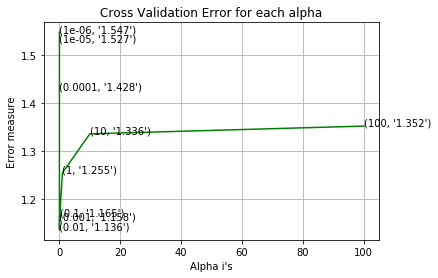

For values of best alpha =  0.01 The train log loss is: 0.6454499813621267
For values of best alpha =  0.01 The cross validation log loss is: 1.1359927597224393
For values of best alpha =  0.01 The test log loss is: 1.3249592517556614


In [192]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_2, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_2, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.1.3.2. Testing the model with best hyper paramters</h5>

Log loss : 1.3249592517556614
Number of mis-classified points : 273 among total points:  665
Percentage of misclassified points :  41.05263157894737
-------------------- Confusion matrix --------------------


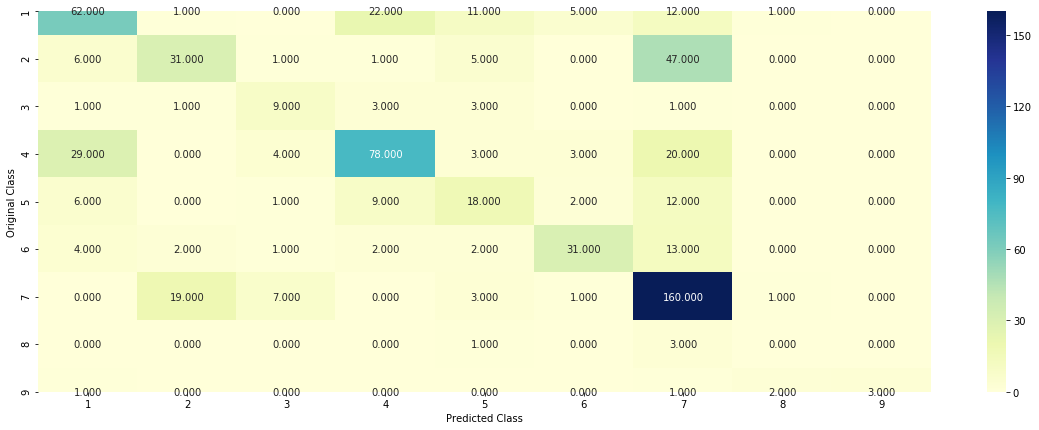

-------------------- Precision matrix (Columm Sum=1) --------------------


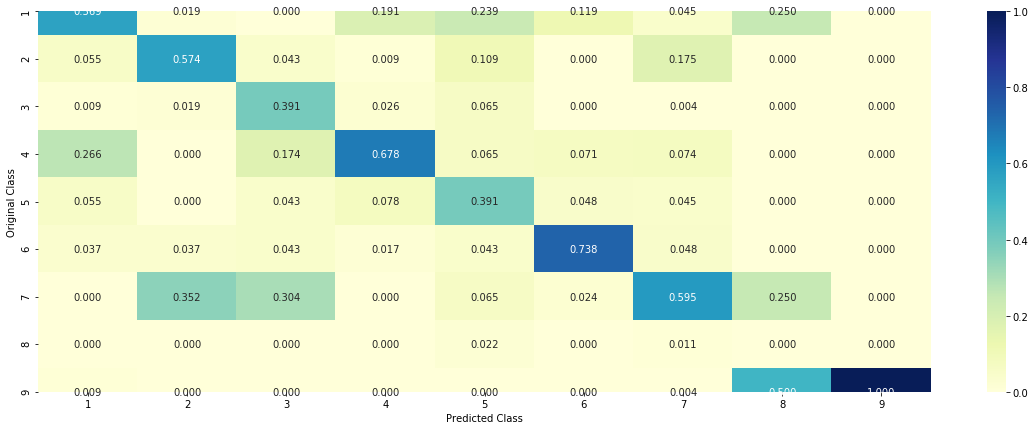

-------------------- Recall matrix (Row sum=1) --------------------


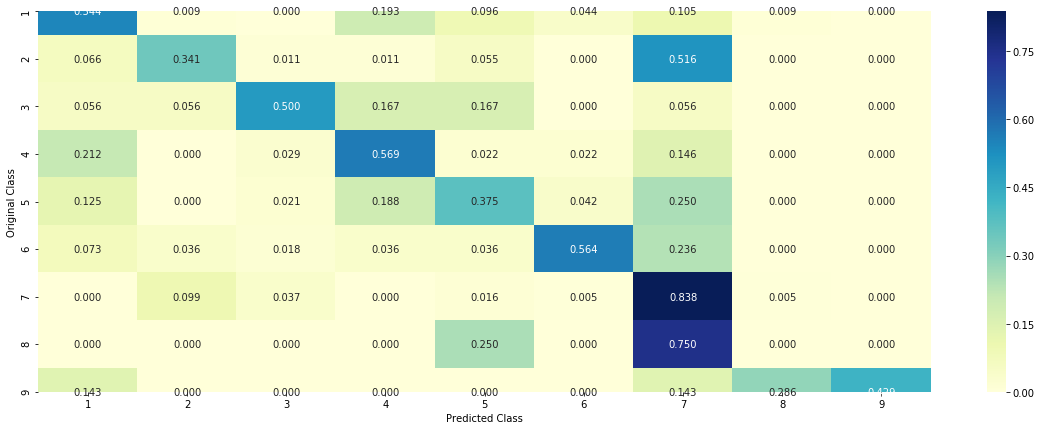

In [193]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_2, train_y, test_x_onehotCoding_2, test_y, clf)

In [194]:
def get_impfeature_names_2(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3, ngram_range=(1,2))
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene.strip() else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var.strip() else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in the query point")

<h5>4.3.1.3.3. Feature Importance - Correctly Classified point</h5>

In [195]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_2, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_2[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_2[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_2(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1851 0.1765 0.0151 0.1476 0.0403 0.0499 0.3652 0.0082 0.0121]]
Actual Class : 7
--------------------------------------------------
80 Text feature [function] present in test data point [True]
94 Text feature [predicted] present in test data point [True]
102 Text feature [conserved] present in test data point [True]
118 Text feature [affected] present in test data point [True]
121 Text feature [sequence] present in test data point [True]
123 Text feature [protein] present in test data point [True]
126 Text feature [dna] present in test data point [True]
132 Text feature [loss] present in test data point [True]
135 Text feature [functional] present in test data point [True]
138 Text feature [alignment] present in test data point [True]
141 Text feature [affect] present in test data point [True]
158 Text feature [family] present in test data point [True]
176 Text feature [amino] present in test data point [True]
204 Text feature [acid

<h5>4.3.1.3.4. Feature Importance - Incorrectly Classified point</h5>

In [196]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_2[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_2[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_2(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.9391 0.0153 0.0015 0.0053 0.0042 0.0036 0.0229 0.0048 0.0033]]
Actual Class : 1
--------------------------------------------------
74 Text feature [kinase] present in test data point [True]
195 Text feature [mutants] present in test data point [True]
204 Text feature [mutations] present in test data point [True]
213 Text feature [activity] present in test data point [True]
222 Text feature [elevated] present in test data point [True]
232 Text feature [showed] present in test data point [True]
234 Text feature [inhibitor] present in test data point [True]
242 Text feature [mutant] present in test data point [True]
265 Text feature [enhanced] present in test data point [True]
267 Text feature [active] present in test data point [True]
293 Text feature [domain] present in test data point [True]
297 Text feature [found] present in test data point [True]
339 Text feature [although] present in test data point [True]
343 Text feature [2c]

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Using one-hot encoding features</h4>

<h5>4.3.2.1.1. Hyper paramter tuning</h5>

For values of alpha =  1e-06 The log loss is: 1.299415862560436
For values of alpha =  1e-05 The log loss is: 1.2758019040414805
For values of alpha =  0.0001 The log loss is: 1.1127866530675963
For values of alpha =  0.001 The log loss is: 1.0800136349348193
For values of alpha =  0.01 The log loss is: 1.1440415518880336
For values of alpha =  0.1 The log loss is: 1.3540062937572312
For values of alpha =  1 The log loss is: 1.583683547247746
For values of alpha =  10 The log loss is: 1.6210306744985459
For values of alpha =  100 The log loss is: 1.6253068992061623


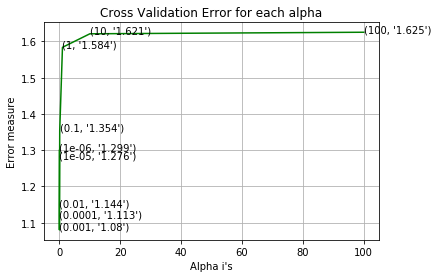

For values of best alpha =  0.001 The train log loss is: 0.5142642103629723
For values of best alpha =  0.001 The cross validation log loss is: 1.0558030847817585
For values of best alpha =  0.001 The test log loss is: 1.2566191559980855


In [206]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.2.1.2. Testing the model with best hyper paramters</h5>

Log loss : 1.2494778353930425
Number of mis-classified points : 249 among total points:  665
Percentage of misclassified points :  37.44360902255639
-------------------- Confusion matrix --------------------


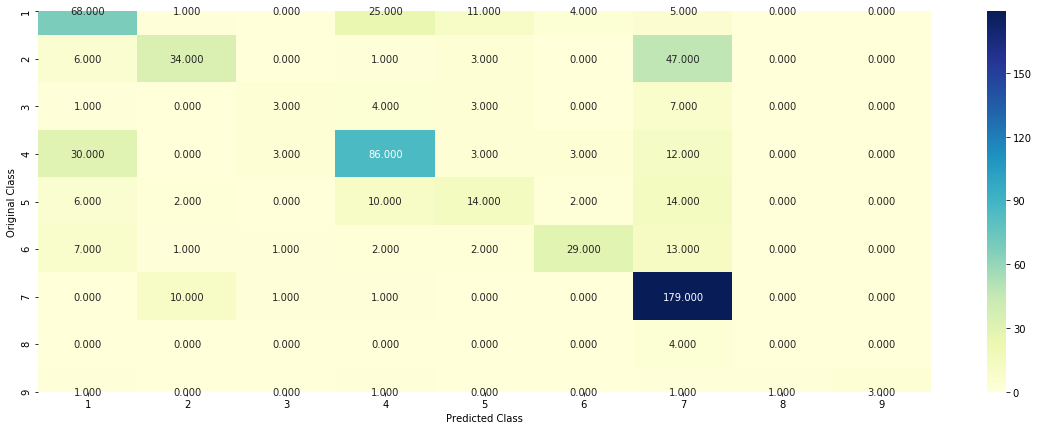

-------------------- Precision matrix (Columm Sum=1) --------------------


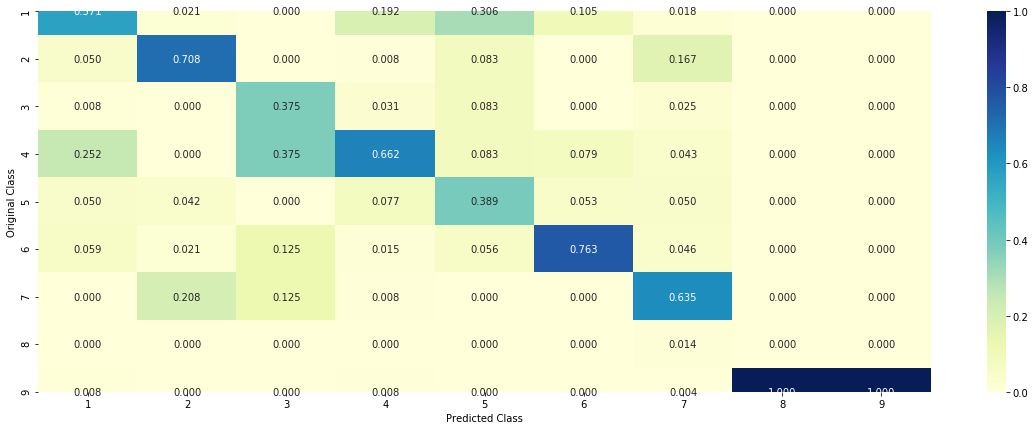

-------------------- Recall matrix (Row sum=1) --------------------


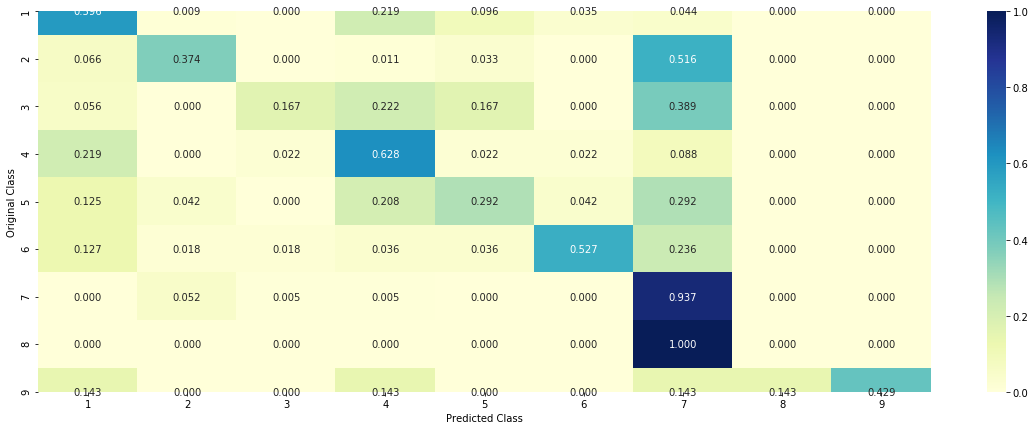

In [207]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

<h5>4.3.2.1.3. Feature Importance - Incorrectly Classified point</h5>

In [208]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1441 0.1821 0.0095 0.1618 0.029  0.0648 0.3846 0.0103 0.0138]]
Actual Class : 7
--------------------------------------------------
228 Text feature [transforming] present in test data point [True]
324 Text feature [transformation] present in test data point [True]
342 Text feature [agar] present in test data point [True]
399 Text feature [transformed] present in test data point [True]
424 Text feature [activating] present in test data point [True]
433 Text feature [expressing] present in test data point [True]
481 Text feature [modeled] present in test data point [True]
486 Text feature [subcutaneously] present in test data point [True]
Out of the top  500  features  8 are present in the query point


<h5>4.3.2.1.4. Feature Importance - Incorrectly Classified point</h5>

In [209]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.623e-01 7.100e-03 5.000e-04 3.300e-03 1.900e-03 2.400e-03 1.880e-02
  3.400e-03 2.000e-04]]
Actual Class : 1
--------------------------------------------------
338 Text feature [kinase] present in test data point [True]
Out of the top  500  features  1 are present in the query point


<h4>4.3.2.2. Using TFIDF features</h4>

<h5>4.3.2.2.1. Hyper paramter tuning</h5>

For values of alpha =  1e-06 The log loss is: 1.1467410794370037
For values of alpha =  1e-05 The log loss is: 1.035495749740118
For values of alpha =  0.0001 The log loss is: 0.9626199906951334
For values of alpha =  0.001 The log loss is: 1.041963542802137
For values of alpha =  0.01 The log loss is: 1.3250987267448424
For values of alpha =  0.1 The log loss is: 1.7466966657243648
For values of alpha =  1 The log loss is: 1.850907747351573
For values of alpha =  10 The log loss is: 1.8658318552167406
For values of alpha =  100 The log loss is: 1.8676478990872942


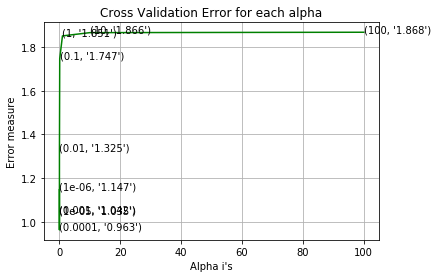

For values of best alpha =  0.0001 The train log loss is: 0.5233736351332338
For values of best alpha =  0.0001 The cross validation log loss is: 0.9289301430025526
For values of best alpha =  0.0001 The test log loss is: 1.1194986726081553


In [197]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.2.2.2. Testing the model with best hyper paramters</h5>

Log loss : 1.12098601277773
Number of mis-classified points : 252 among total points:  665
Percentage of misclassified points :  37.89473684210527
-------------------- Confusion matrix --------------------


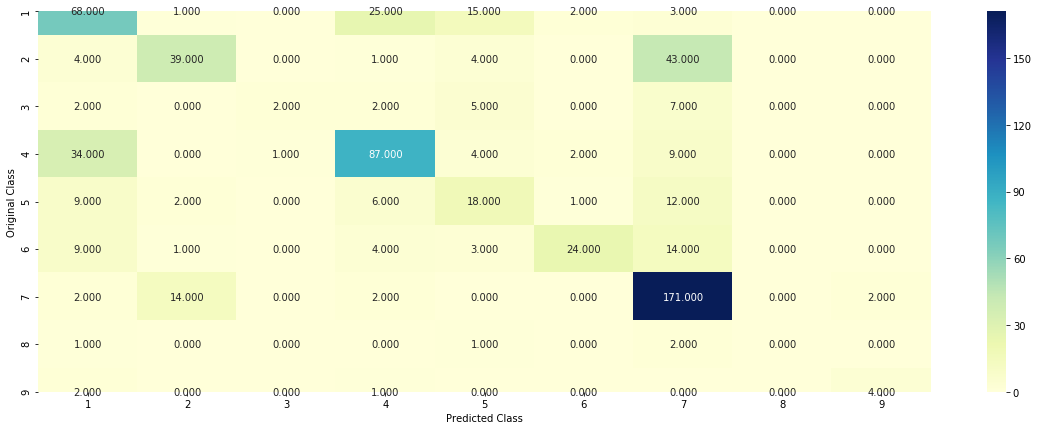

-------------------- Precision matrix (Columm Sum=1) --------------------


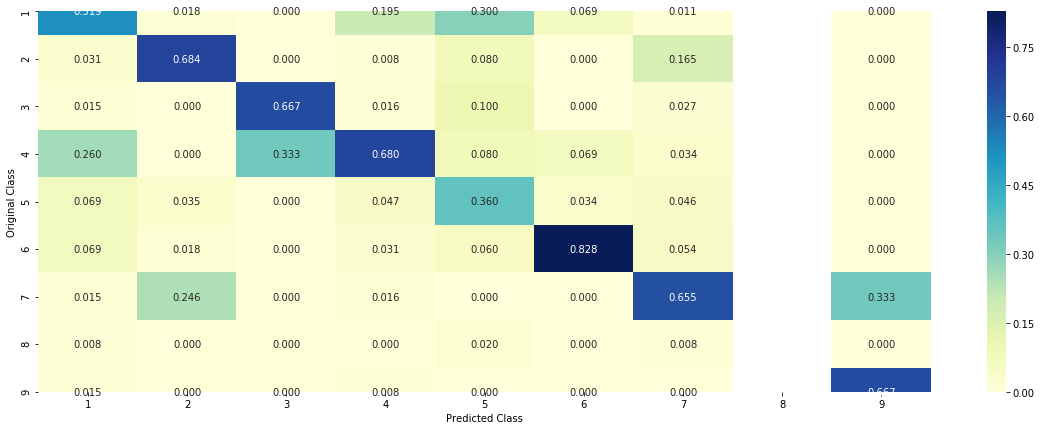

-------------------- Recall matrix (Row sum=1) --------------------


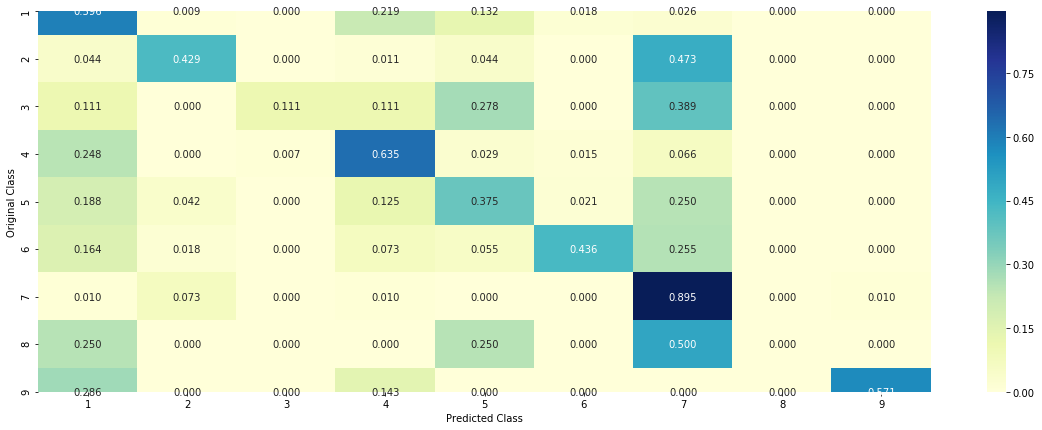

In [198]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

<h5>4.3.2.2.3. Feature Importance - Incorrectly Classified point</h5>

In [199]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1732 0.0988 0.0005 0.2807 0.0333 0.0495 0.3445 0.018  0.0014]]
Actual Class : 7
--------------------------------------------------
8 Text feature [3b] present in test data point [True]
11 Text feature [enhanced] present in test data point [True]
31 Text feature [colony] present in test data point [True]
40 Text feature [approximately] present in test data point [True]
44 Text feature [overexpression] present in test data point [True]
55 Text feature [positive] present in test data point [True]
64 Text feature [panel] present in test data point [True]
78 Text feature [detection] present in test data point [True]
87 Text feature [discovery] present in test data point [True]
92 Text feature [grade] present in test data point [True]
93 Text feature [days] present in test data point [True]
107 Text feature [express] present in test data point [True]
114 Text feature [reduced] present in test data point [True]
119 Text feature [transform

<h5>4.3.2.2.4. Feature Importance - Correctly Classified point</h5>

In [200]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tfidf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.137e-01 1.250e-02 1.900e-03 1.820e-02 3.300e-03 1.780e-02 2.830e-02
  3.400e-03 9.000e-04]]
Actual Class : 1
--------------------------------------------------
22 Text feature [surface] present in test data point [True]
28 Text feature [panel] present in test data point [True]
29 Text feature [repeats] present in test data point [True]
51 Text feature [hydrophobic] present in test data point [True]
54 Text feature [mm] present in test data point [True]
86 Text feature [occur] present in test data point [True]
101 Text feature [blue] present in test data point [True]
108 Text feature [calculated] present in test data point [True]
109 Text feature [target] present in test data point [True]
117 Text feature [structure] present in test data point [True]
123 Text feature [suppressor] present in test data point [True]
124 Text feature [function] present in test data point [True]
155 Text feature [brain] present in test data point [True]


<h4>4.3.2.3. Using one-hot encoding features - with bigram</h4>

<h5>4.3.2.3.1. Hyper paramter tuning</h5>

For values of alpha =  1e-06 The log loss is: 1.4647519015085413
For values of alpha =  1e-05 The log loss is: 1.452467417632035
For values of alpha =  0.0001 The log loss is: 1.3857105262312135
For values of alpha =  0.001 The log loss is: 1.163271728452122
For values of alpha =  0.01 The log loss is: 1.1416784781631157
For values of alpha =  0.1 The log loss is: 1.1702505984293856
For values of alpha =  1 The log loss is: 1.2566799880984592
For values of alpha =  10 The log loss is: 1.321089263998945
For values of alpha =  100 The log loss is: 1.3350974522204089


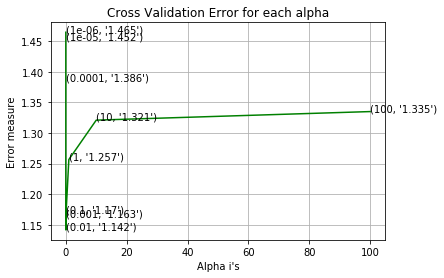

For values of best alpha =  0.01 The train log loss is: 0.6454499813621267
For values of best alpha =  0.01 The cross validation log loss is: 1.1359927597224393
For values of best alpha =  0.01 The test log loss is: 1.3249592517556614


In [201]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_2, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_2, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h5>4.3.2.3.2. Testing the model with best hyper paramters</h5>

Log loss : 1.3113274274337765
Number of mis-classified points : 272 among total points:  665
Percentage of misclassified points :  40.902255639097746
-------------------- Confusion matrix --------------------


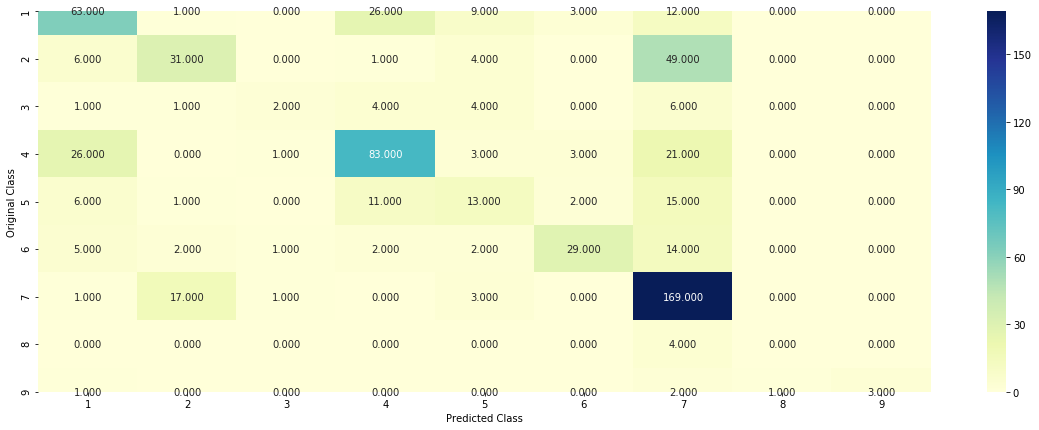

-------------------- Precision matrix (Columm Sum=1) --------------------


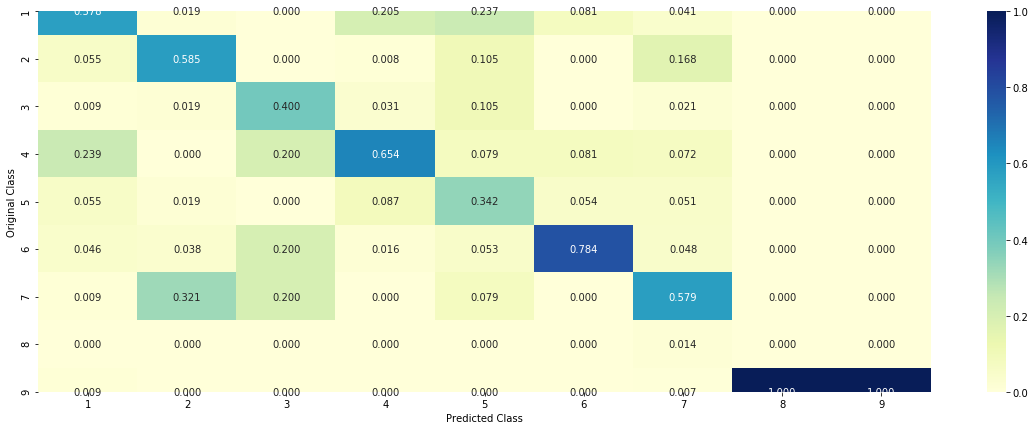

-------------------- Recall matrix (Row sum=1) --------------------


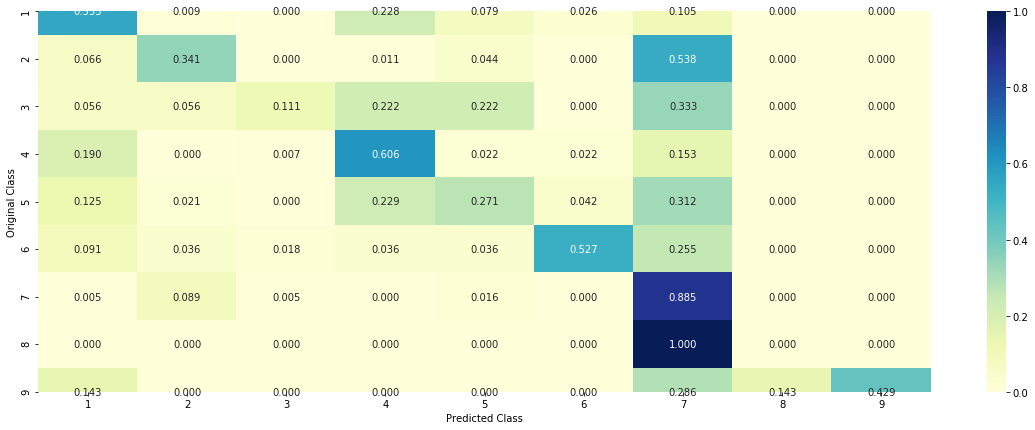

In [202]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_2, train_y, test_x_onehotCoding_2, test_y, clf)

<h5>4.3.2.3.3. Feature Importance - Correctly Classified point</h5>

In [203]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_2, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_2[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_2[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_2(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1825 0.1787 0.0203 0.141  0.0424 0.0504 0.3674 0.0072 0.0101]]
Actual Class : 7
--------------------------------------------------
309 Text feature [function] present in test data point [True]
460 Text feature [conserved] present in test data point [True]
478 Text feature [predicted] present in test data point [True]
Out of the top  500  features  3 are present in the query point


<h5>4.3.2.3.4. Feature Importance - Incorrectly Classified point</h5>

In [204]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding_2[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding_2[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_2(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.9399 0.0156 0.0022 0.0052 0.0042 0.0033 0.0247 0.0033 0.0015]]
Actual Class : 1
--------------------------------------------------
166 Text feature [kinase] present in test data point [True]
353 Text feature [mutants] present in test data point [True]
356 Text feature [elevated] present in test data point [True]
403 Text feature [mutations] present in test data point [True]
404 Text feature [inhibitor] present in test data point [True]
427 Text feature [activity] present in test data point [True]
450 Text feature [enhanced] present in test data point [True]
458 Text feature [active] present in test data point [True]
467 Text feature [showed] present in test data point [True]
Out of the top  500  features  9 are present in the query point


<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Using One-hot encoding</h3>

<h4>4.4.1.1. Hyper paramter tuning</h4>

For values of alpha =  1e-05 The log loss is: 1.3096917086185893
For values of alpha =  0.0001 The log loss is: 1.2085892003538363
For values of alpha =  0.001 The log loss is: 1.124084526259967
For values of alpha =  0.01 The log loss is: 1.1234562062569609
For values of alpha =  0.1 The log loss is: 1.372545001400975
For values of alpha =  1 The log loss is: 1.7347350975581184
For values of alpha =  10 The log loss is: 1.7519514445087043
For values of alpha =  100 The log loss is: 1.7519506134512992


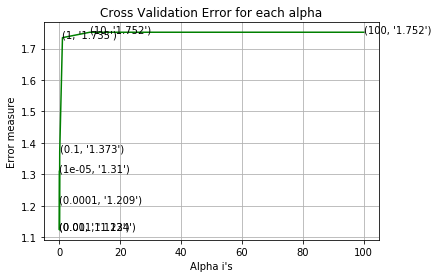

For values of best alpha =  0.01 The train log loss is: 0.7376829096921795
For values of best alpha =  0.01 The cross validation log loss is: 1.1049128793055607
For values of best alpha =  0.01 The test log loss is: 1.3184502529510755


In [210]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.4.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.2882099593855927
Number of mis-classified points : 266 among total points:  665
Percentage of misclassified points :  40.0
-------------------- Confusion matrix --------------------


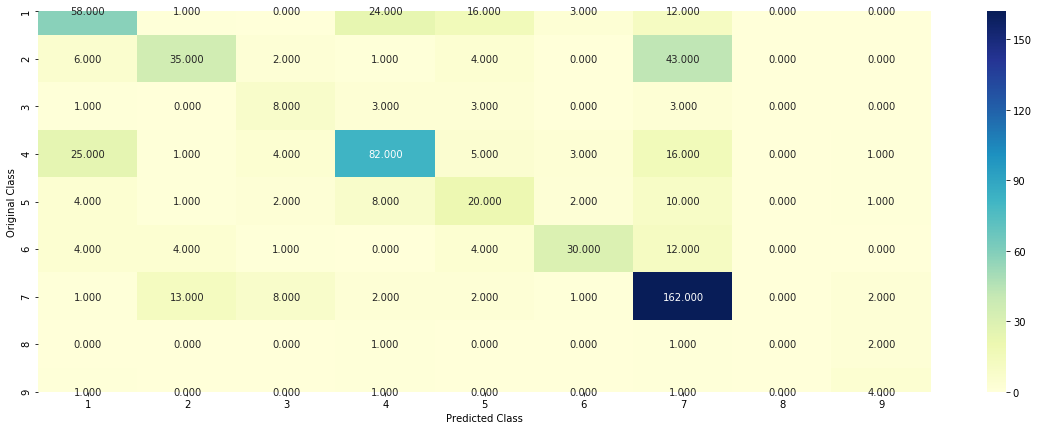

-------------------- Precision matrix (Columm Sum=1) --------------------


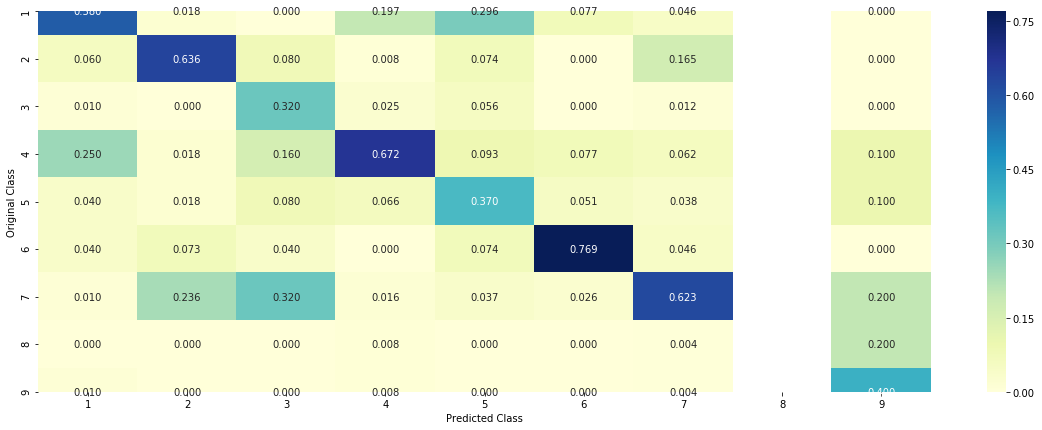

-------------------- Recall matrix (Row sum=1) --------------------


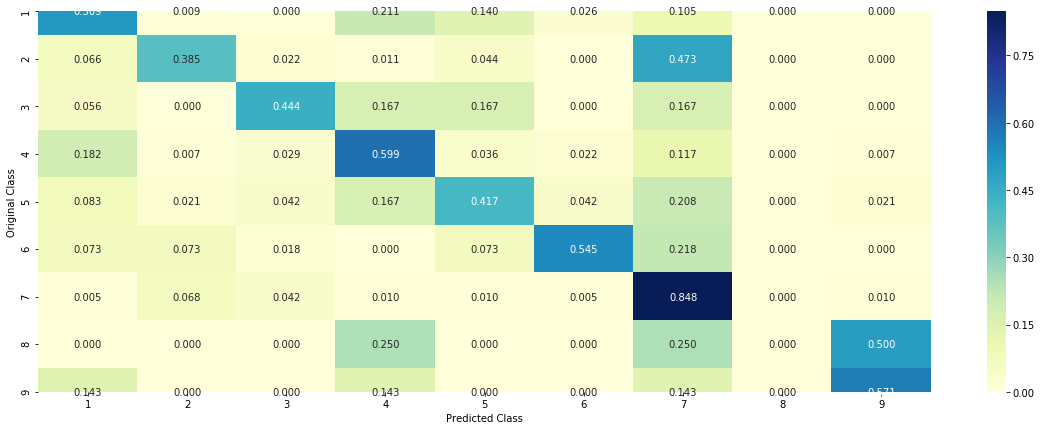

In [211]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

<h4>4.4.1.3. Feature Importance - Incorrectly Classified point</h4>

In [212]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1783 0.1326 0.0145 0.1931 0.0437 0.0768 0.3321 0.0081 0.0208]]
Actual Class : 7
--------------------------------------------------
314 Text feature [subcutaneously] present in test data point [True]
367 Text feature [transformed] present in test data point [True]
376 Text feature [express] present in test data point [True]
438 Text feature [independently] present in test data point [True]
Out of the top  500  features  4 are present in the query point


<h4>4.4.1.4. Feature Importance - Correctly Classified point</h4>

In [213]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.8185 0.0345 0.0061 0.035  0.0158 0.0208 0.0629 0.0043 0.0021]]
Actual Class : 1
--------------------------------------------------
322 Text feature [651] present in test data point [True]
Out of the top  500  features  1 are present in the query point


<h3>4.4.2. Using TFIDF encoding</h3>

<h4>4.4.2.1. Hyper paramter tuning</h4>

For values of alpha =  1e-05 The log loss is: 1.0969296555424557
For values of alpha =  0.0001 The log loss is: 1.0612771826265488
For values of alpha =  0.001 The log loss is: 1.063884947220554
For values of alpha =  0.01 The log loss is: 1.3165315885183337
For values of alpha =  0.1 The log loss is: 1.6366866878617723
For values of alpha =  1 The log loss is: 1.7938043131740609
For values of alpha =  10 The log loss is: 1.7938042091198023
For values of alpha =  100 The log loss is: 1.7938043640536776


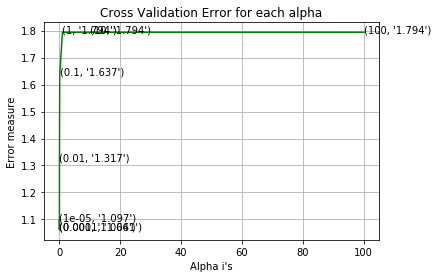

For values of best alpha =  0.0001 The train log loss is: 0.5233736351332338
For values of best alpha =  0.0001 The cross validation log loss is: 0.9289301430025526
For values of best alpha =  0.0001 The test log loss is: 1.1194986726081553


In [214]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    present_log_loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    cv_log_error_array.append(present_log_loss)
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print('For values of alpha = ', i, "The log loss is:",present_log_loss)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.4.2.2. Testing the model with best hyper paramters</h4>

Log loss : 1.2211097551303065
Number of mis-classified points : 257 among total points:  665
Percentage of misclassified points :  38.64661654135338
-------------------- Confusion matrix --------------------


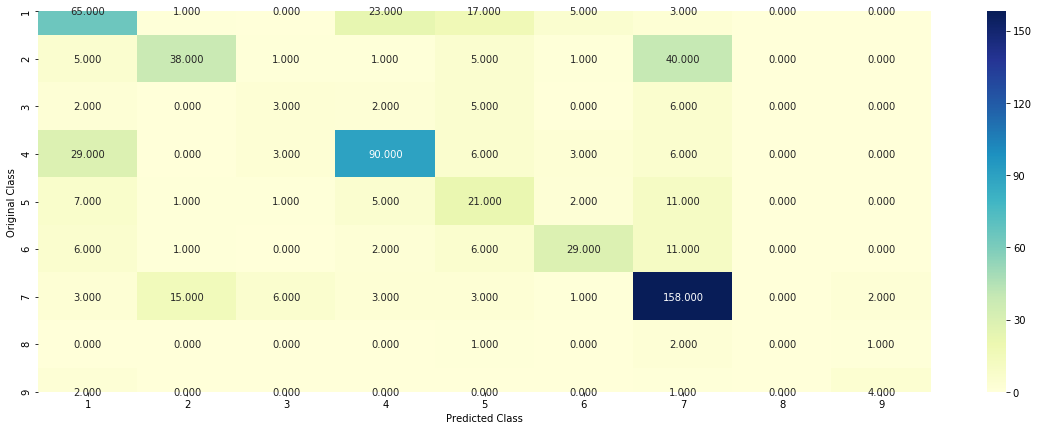

-------------------- Precision matrix (Columm Sum=1) --------------------


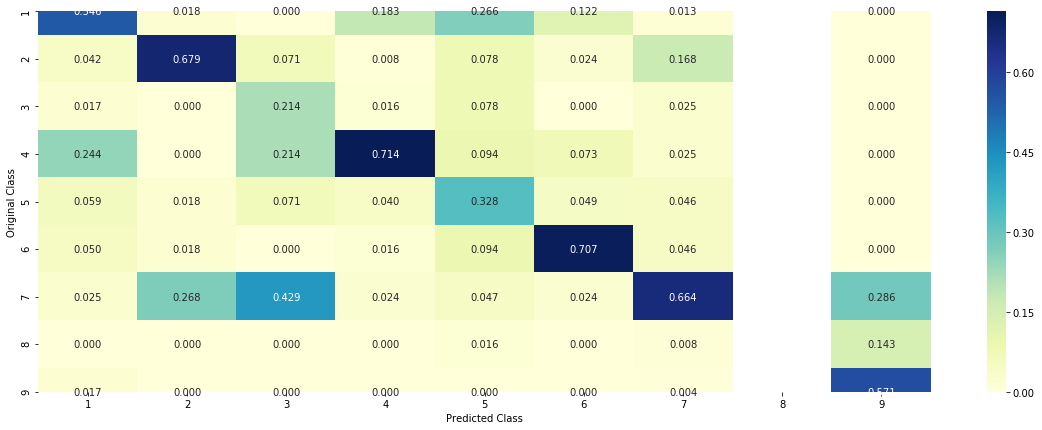

-------------------- Recall matrix (Row sum=1) --------------------


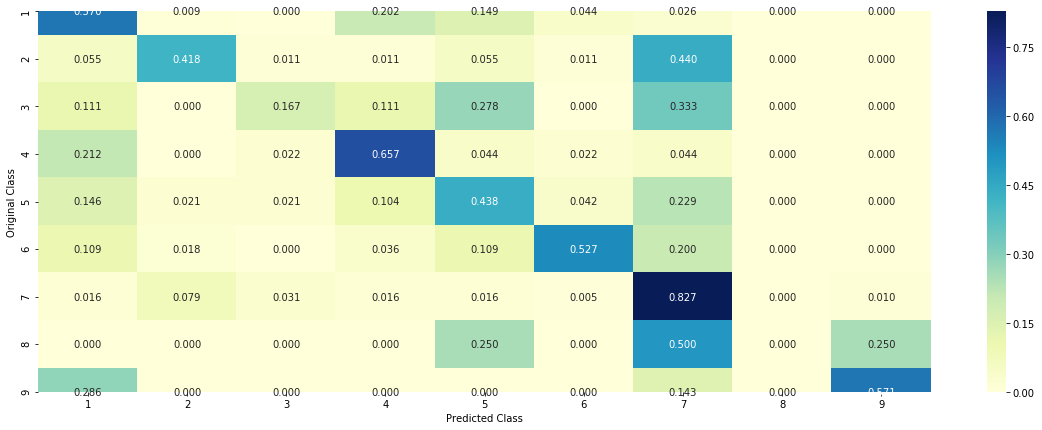

In [215]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_x_tfidf, test_y, clf)

<h4>4.4.2.3. Feature Importance - Incorrectly Classified point</h4>

In [216]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf,train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1068 0.0398 0.0012 0.1491 0.0371 0.0686 0.5634 0.0113 0.0226]]
Actual Class : 7
--------------------------------------------------
497 Text feature [000] present in test data point [True]
Out of the top  500  features  1 are present in the query point


<h4>4.4.2.4. Feature Importance - Correctly Classified point</h4>

In [217]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7474 0.056  0.0126 0.0631 0.0032 0.036  0.0765 0.0025 0.0028]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in the query point


<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Using One hot Encoding</h3>

<h4>4.5.1.1. Hyper paramter tuning </h4>

In [218]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("For n_estimators =", i,"and max depth = ", j," : Log Loss = ",log_loss(cv_y, sig_clf_probs)) 

#The plot is not shown here as it is hard to interpret

best_alpha = np.argmin(cv_log_error_array)
#The index for best n_estimators is (best_alpha/2) and that for max_depth in (best_alpha%2)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 100 and max depth =  5  : Log Loss =  1.2157114019124924
For n_estimators = 100 and max depth =  10  : Log Loss =  1.1442803692620334
For n_estimators = 200 and max depth =  5  : Log Loss =  1.2063931667778771
For n_estimators = 200 and max depth =  10  : Log Loss =  1.1335400368403097
For n_estimators = 500 and max depth =  5  : Log Loss =  1.201435461484492
For n_estimators = 500 and max depth =  10  : Log Loss =  1.1335315908113874
For n_estimators = 1000 and max depth =  5  : Log Loss =  1.2017959319245308
For n_estimators = 1000 and max depth =  10  : Log Loss =  1.1365493107612177
For n_estimators = 2000 and max depth =  5  : Log Loss =  1.2037122653856098
For n_estimators = 2000 and max depth =  10  : Log Loss =  1.1372918366798246
For values of best estimator =  500 The train log loss is: 0.6757809848447784
For values of best estimator =  500 The cross validation log loss is: 1.1335315908113874
For values of best estimator =  500 The test log loss is: 1.22520

<h4>4.5.1.2. Testing model with best hyper parameters</h4>

Log loss : 1.2252069067978222
Number of mis-classified points : 273 among total points:  665
Percentage of misclassified points :  41.05263157894737
-------------------- Confusion matrix --------------------


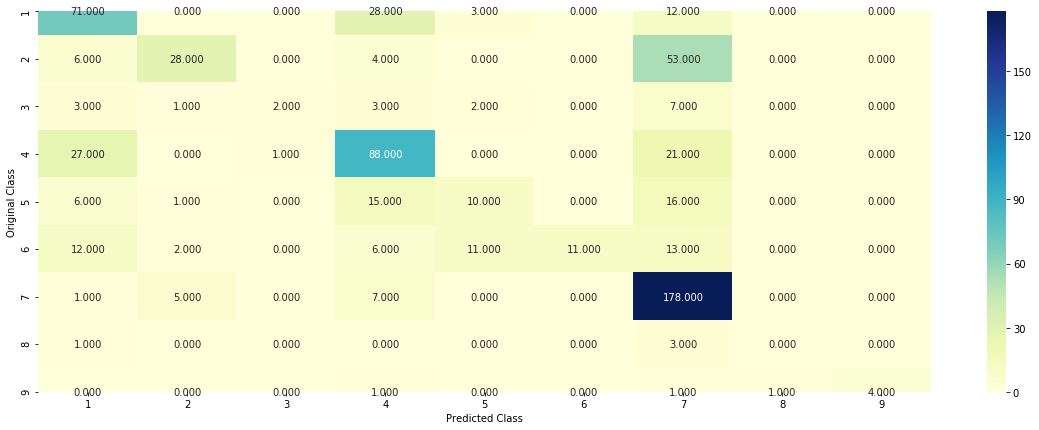

-------------------- Precision matrix (Columm Sum=1) --------------------


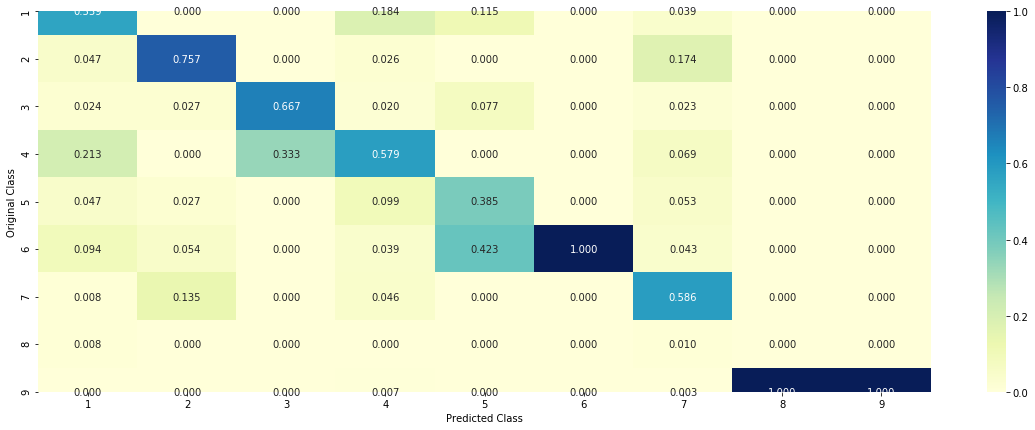

-------------------- Recall matrix (Row sum=1) --------------------


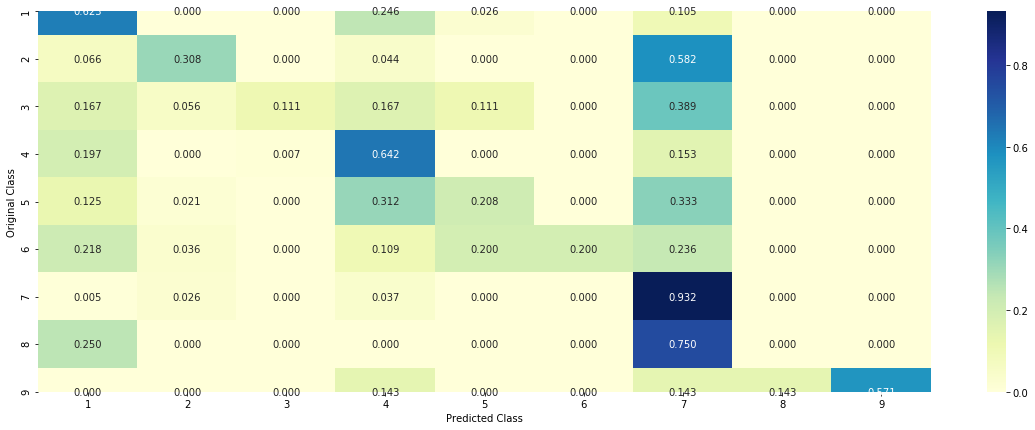

In [219]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,test_x_onehotCoding,test_y, clf)

<h4>4.5.1.3. Feature Importance - Correctly Classified point</h4>

In [220]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0393 0.0162 0.0189 0.1387 0.0365 0.7256 0.0177 0.0033 0.0039]]
Actual Class : 6
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [activation] present in test data point [True]
4 Text feature [suppressor] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
7 Text feature [tyrosine] present in test data point [True]
8 Text feature [nonsense] present in test data point [True]
9 Text feature [missense] present in test data point [True]
10 Text feature [therapeutic] present in test data point [True]
13 Text feature [inhibitor] present in test data point [True]
17 Text feature [function] present in test data point [True]
18 Text feature [brca1] present in test data point [True]
25 Text feature [cells] present in test data point [True]
30 Text feature [expressing] present in test data point [True]
32 Text feature [growth]

<h4>4.5.1.4. Feature Importance - Incorrectly Classified point</h4>

In [221]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.7504 0.0278 0.0137 0.078  0.0347 0.0413 0.0451 0.0036 0.0054]]
Actuall Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
4 Text feature [suppressor] present in test data point [True]
9 Text feature [missense] present in test data point [True]
12 Text feature [phosphorylation] present in test data point [True]
13 Text feature [inhibitor] present in test data point [True]
17 Text feature [function] present in test data point [True]
25 Text feature [cells] present in test data point [True]
29 Text feature [akt] present in test data point [True]
31 Text feature [active] present in test data point [True]
32 Text feature [growth] present in test data point [True]
36 Text feature [trials] present in test data point [True]
41 Text feature [variants] present in test data point [True]
42 Text feature [erk] present in test data point [True]
48 Text feature [loss] present in 

<h3>4.5.2. Using Response Coding</h3>

<h4>4.5.2.1. Hyper parameter Tuning </h4>

In [222]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("For n_estimators =", i,"and max depth = ", j," : Log Loss = ",log_loss(cv_y, sig_clf_probs)) 

#The plot is not shown here as it is hard to interpret

best_alpha = np.argmin(cv_log_error_array)
#The index for best n_estimators is (best_alpha/2) and that for max_depth in (best_alpha%2)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 10 and max depth =  2  : Log Loss =  1.9740717404812405
For n_estimators = 10 and max depth =  3  : Log Loss =  1.5938748382521937
For n_estimators = 10 and max depth =  5  : Log Loss =  1.4007785165831514
For n_estimators = 10 and max depth =  10  : Log Loss =  1.7595346966356775
For n_estimators = 50 and max depth =  2  : Log Loss =  1.6038739101622779
For n_estimators = 50 and max depth =  3  : Log Loss =  1.3793800223123005
For n_estimators = 50 and max depth =  5  : Log Loss =  1.3592069335447226
For n_estimators = 50 and max depth =  10  : Log Loss =  1.705605234403686
For n_estimators = 100 and max depth =  2  : Log Loss =  1.493891974730505
For n_estimators = 100 and max depth =  3  : Log Loss =  1.3892433853667445
For n_estimators = 100 and max depth =  5  : Log Loss =  1.313198087288735
For n_estimators = 100 and max depth =  10  : Log Loss =  1.647996252267891
For n_estimators = 200 and max depth =  2  : Log Loss =  1.5274149878990146
For n_estimators = 20

<h4>4.5.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.4381901285214773
Number of mis-classified points : 332 among total points:  665
Percentage of misclassified points :  49.92481203007519
-------------------- Confusion matrix --------------------


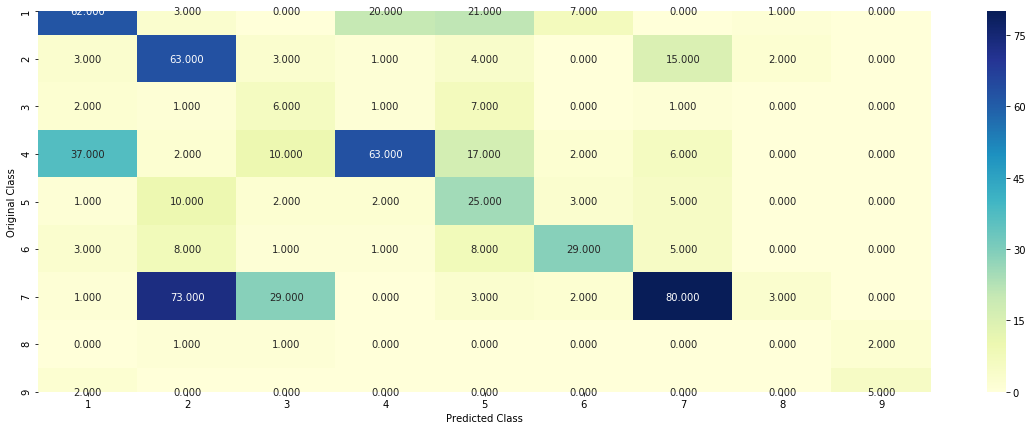

-------------------- Precision matrix (Columm Sum=1) --------------------


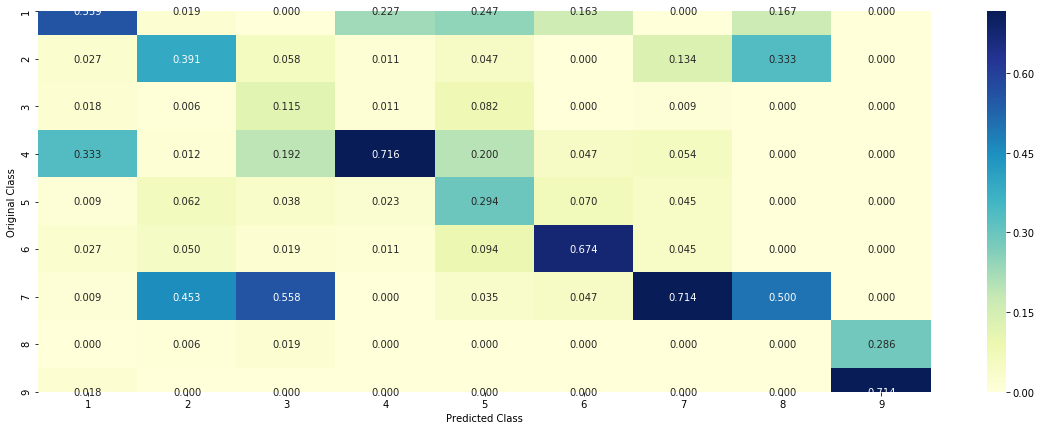

-------------------- Recall matrix (Row sum=1) --------------------


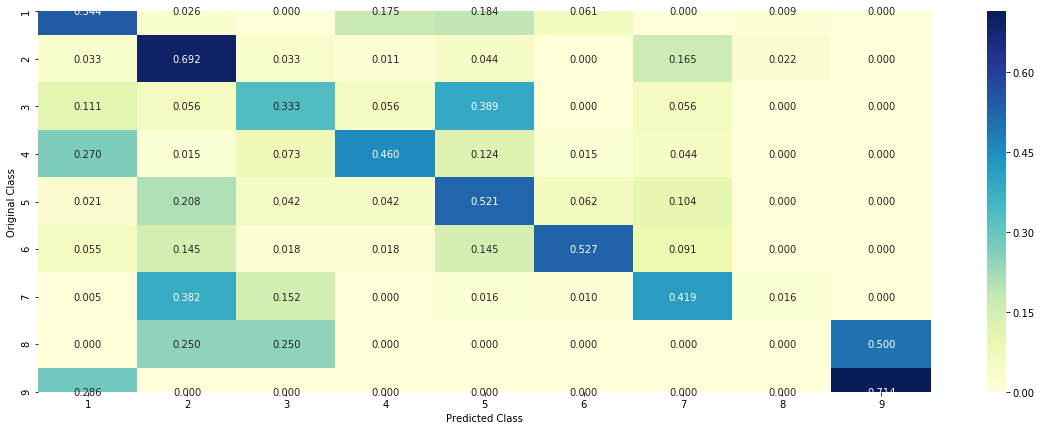

In [223]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,test_x_responseCoding,test_y, clf)

<h4>4.5.2.3. Feature Importance - Correctly Classified point</h4>

In [224]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2552 0.0267 0.0293 0.2932 0.1041 0.2255 0.0596 0.0033 0.0032]]
Actual Class : 6
--------------------------------------------------
0 Text feature [missense] present in test data point [True]
4 Text feature [kinase] present in test data point [True]
5 Text feature [suppressor] present in test data point [True]
7 Text feature [function] present in test data point [True]
11 Text feature [therapeutic] present in test data point [True]
12 Text feature [growth] present in test data point [True]
14 Text feature [activation] present in test data point [True]
16 Text feature [brct] present in test data point [True]
19 Text feature [carriers] present in test data point [True]
21 Text feature [nonsense] present in test data point [True]
22 Text feature [concentrations] present in test data point [True]
27 Text feature [proliferation] present in test data point [True]
32 Text feature [defective] present in test data point [True]
35 Text featur

<h4>4.5.2.4. Feature Importance - Incorrectly Classified point</h4>

In [225]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.3043 0.0554 0.024  0.3542 0.0554 0.0649 0.1128 0.0048 0.0242]]
Actuall Class : 1
--------------------------------------------------
0 Text feature [missense] present in test data point [True]
4 Text feature [kinase] present in test data point [True]
5 Text feature [suppressor] present in test data point [True]
7 Text feature [function] present in test data point [True]
12 Text feature [growth] present in test data point [True]
22 Text feature [concentrations] present in test data point [True]
26 Text feature [trials] present in test data point [True]
27 Text feature [proliferation] present in test data point [True]
37 Text feature [factor] present in test data point [True]
49 Text feature [variants] present in test data point [True]
52 Text feature [akt] present in test data point [True]
57 Text feature [active] present in test data point [True]
64 Text feature [erk] present in test data point [True]
68 Text feature [inhibitor] pre

<h3>4.5.3. Using TFIDF Encoding</h3>

<h4>4.5.3.1. Hyper parameter Tuning </h4>

In [229]:
alpha = [50,100,200,500,1000,2000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("For n_estimators =", i,"and max depth = ", j," : Log Loss = ",log_loss(cv_y, sig_clf_probs)) 

#The plot is not shown here as it is hard to interpret

best_alpha = np.argmin(cv_log_error_array)
#The index for best n_estimators is (best_alpha/2) and that for max_depth in (best_alpha%2)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 50 and max depth =  2  : Log Loss =  1.339128819881765
For n_estimators = 50 and max depth =  3  : Log Loss =  1.2759975442698164
For n_estimators = 50 and max depth =  5  : Log Loss =  1.1875178270954436
For n_estimators = 50 and max depth =  10  : Log Loss =  1.2217900578612524
For n_estimators = 100 and max depth =  2  : Log Loss =  1.3366102242203768
For n_estimators = 100 and max depth =  3  : Log Loss =  1.255182677256432
For n_estimators = 100 and max depth =  5  : Log Loss =  1.1750274649296892
For n_estimators = 100 and max depth =  10  : Log Loss =  1.1981167783758602
For n_estimators = 200 and max depth =  2  : Log Loss =  1.3243021057856699
For n_estimators = 200 and max depth =  3  : Log Loss =  1.247104912296632
For n_estimators = 200 and max depth =  5  : Log Loss =  1.167544188468343
For n_estimators = 200 and max depth =  10  : Log Loss =  1.1941946137398938
For n_estimators = 500 and max depth =  2  : Log Loss =  1.3239662483828645
For n_estimators 

<h4>4.5.3.2. Testing model with best hyper parameters</h4>

Log loss : 1.2531417063532564
Number of mis-classified points : 298 among total points:  665
Percentage of misclassified points :  44.81203007518797
-------------------- Confusion matrix --------------------


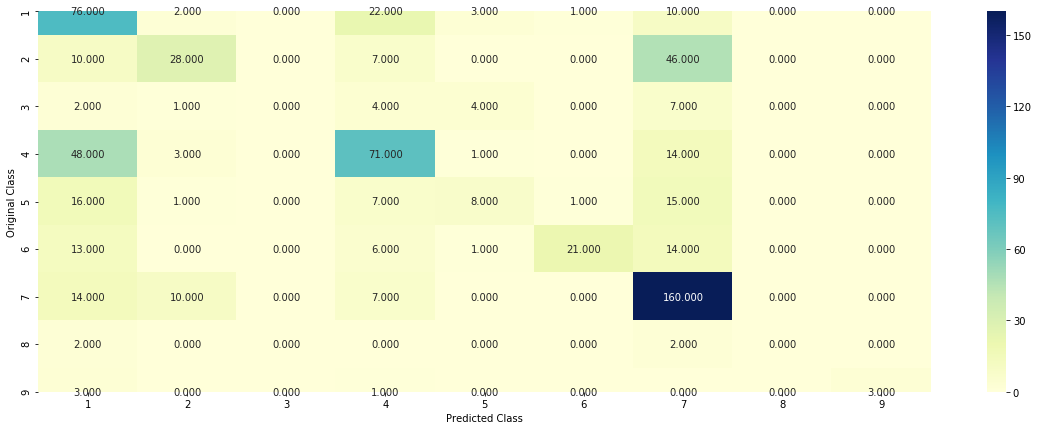

-------------------- Precision matrix (Columm Sum=1) --------------------


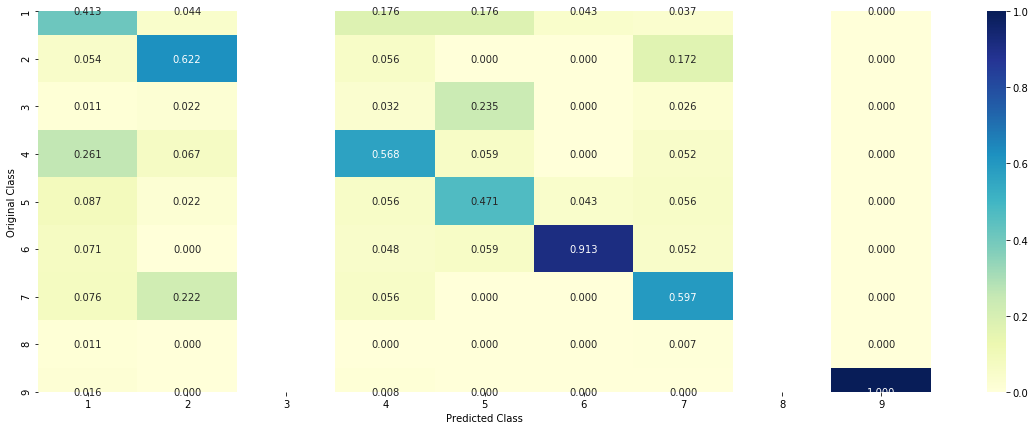

-------------------- Recall matrix (Row sum=1) --------------------


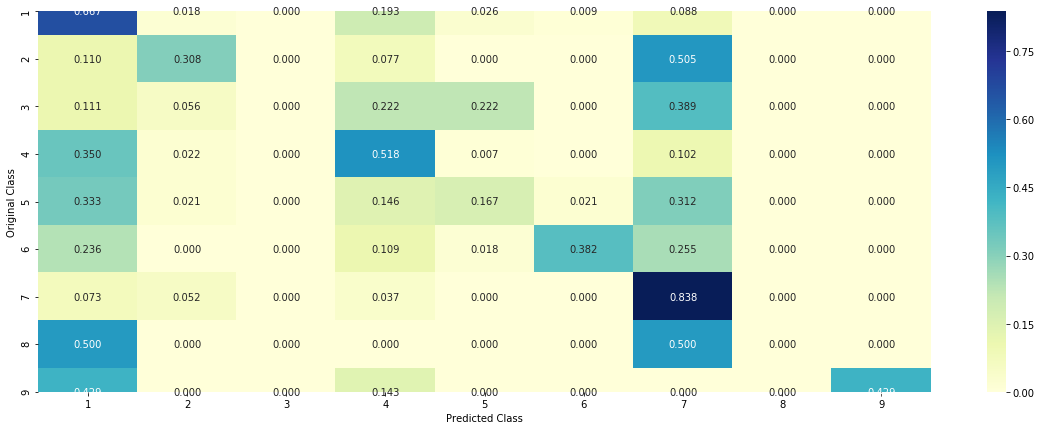

In [230]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,test_x_tfidf,test_y, clf)

<h4>4.5.2.3. Feature Importance - Correctly Classified point</h4>

In [232]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names_tfidf(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.1167 0.0115 0.0114 0.2026 0.0562 0.5686 0.0226 0.0039 0.0065]]
Actual Class : 6
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [function] present in test data point [True]
3 Text feature [suppressor] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
6 Text feature [inhibitors] present in test data point [True]
7 Text feature [activation] present in test data point [True]
9 Text feature [missense] present in test data point [True]
12 Text feature [loss] present in test data point [True]
13 Text feature [inhibitor] present in test data point [True]
15 Text feature [protein] present in test data point [True]
16 Text feature [oncogenic] present in test data point [True]
17 Text feature [deleterious] present in test data point [True]
18 Text feature [pathogenic] present in test data point [True]
19 Text feature [brca1

<h4>4.5.2.4. Feature Importance - Incorrectly Classified point</h4>

In [233]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tfidf[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names_tfidf(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6019 0.0168 0.0095 0.2306 0.0406 0.0476 0.0315 0.0055 0.016 ]]
Actuall Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [function] present in test data point [True]
3 Text feature [suppressor] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
9 Text feature [missense] present in test data point [True]
12 Text feature [loss] present in test data point [True]
13 Text feature [inhibitor] present in test data point [True]
15 Text feature [protein] present in test data point [True]
23 Text feature [erk] present in test data point [True]
26 Text feature [functional] present in test data point [True]
29 Text feature [growth] present in test data point [True]
30 Text feature [classified] present in test data point [True]
32 Text feature [trials] present in test data point [True]
33 Text feature [variants] 

<h2>4.6 Stack the models </h2>

<h3>4.6.1 Using one-hot encoding</h3>

<h4>4.6.1.1. Hyper parameter tuning</h4>

In [234]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.73
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.723
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.324
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.149
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.407
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.699


<h4>4.6.1.2 Testing the model with the best hyper parameters</h4>

Log loss (train) on the stacking classifier : 0.4872136229013086
Log loss (CV) on the stacking classifier : 1.1487082322247026
Log loss (test) on the stacking classifier : 1.286793950964087
Percentage of missclassified point : 0.38345864661654133
-------------------- Confusion matrix --------------------


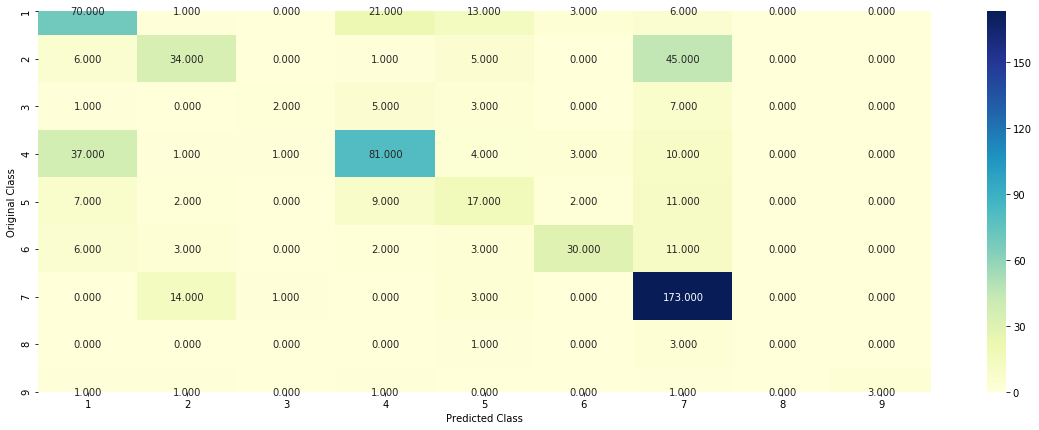

-------------------- Precision matrix (Columm Sum=1) --------------------


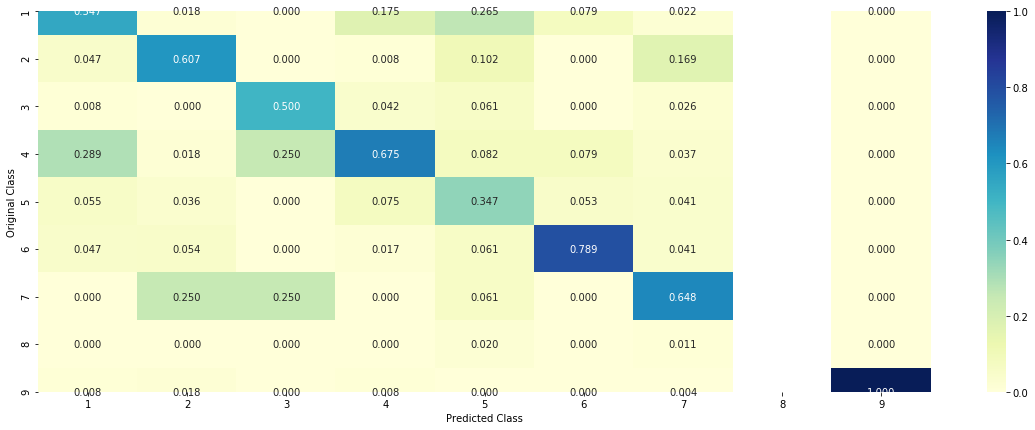

-------------------- Recall matrix (Row sum=1) --------------------


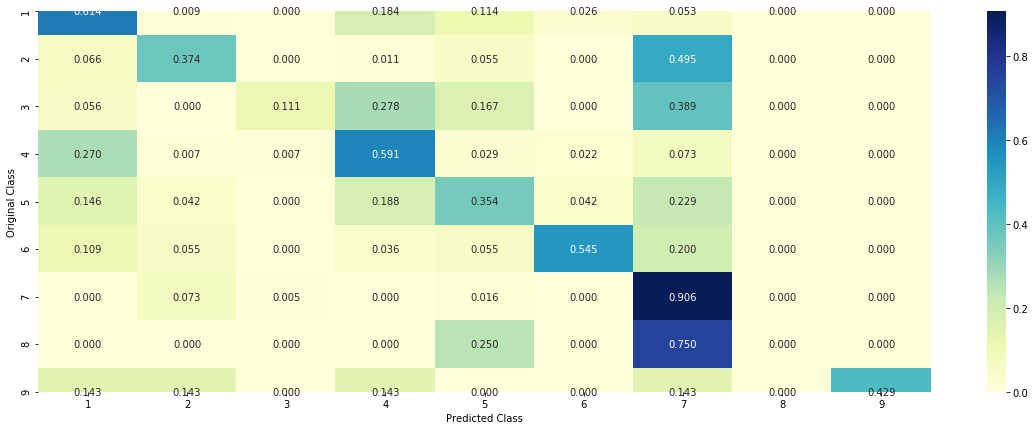

In [235]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)


print("Percentage of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h4>4.6.1.3 Maximum Voting classifier </h4>

Log loss (train) on the VotingClassifier : 0.8561255935501038
Log loss (CV) on the VotingClassifier : 1.1720377506111734
Log loss (test) on the VotingClassifier : 1.2901657317568096
Percentage of missclassified point : 0.39097744360902253
-------------------- Confusion matrix --------------------


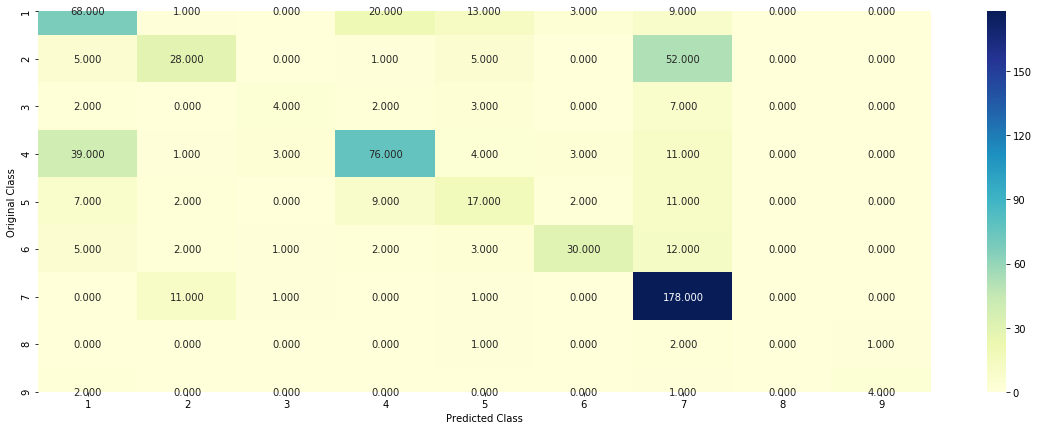

-------------------- Precision matrix (Columm Sum=1) --------------------


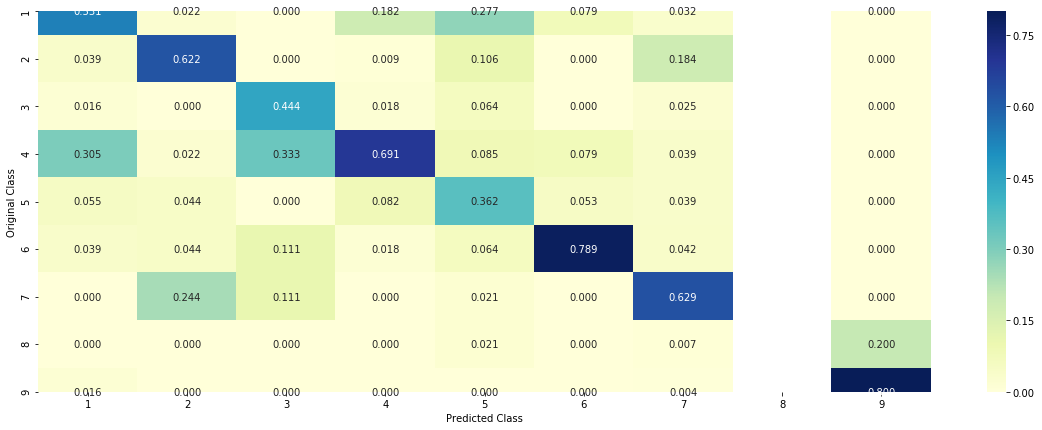

-------------------- Recall matrix (Row sum=1) --------------------


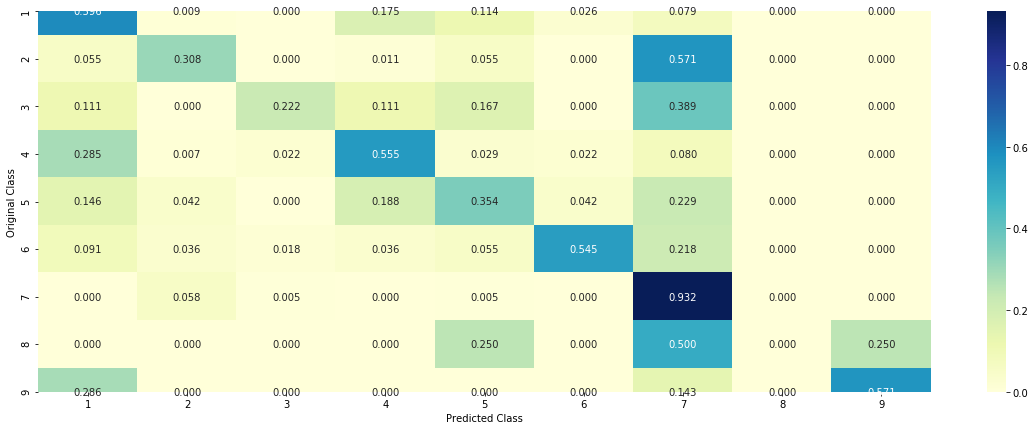

In [236]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Percentage of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

<h3>4.6.2. Using TFIDF encoding</h3>

<h4>4.6.2.1. Hyper parameter tuning</h4>

In [238]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_tfidf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_tfidf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_tfidf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_tfidf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_tfidf))))
sig_clf2.fit(train_x_tfidf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_tfidf))))
sig_clf3.fit(train_x_tfidf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_tfidf))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tfidf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.96
Support vector machines : Log Loss: 1.79
Naive Bayes : Log Loss: 1.14
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.817
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.717
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.317
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.106
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.130
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.161


<h4>4.6.2.2 Testing the model with the best hyper parameters</h4>

Log loss (train) on the stacking classifier : 0.695912384777848
Log loss (CV) on the stacking classifier : 1.1055086707015893
Log loss (test) on the stacking classifier : 1.240465205201189
Percentage of missclassified point : 0.4045112781954887
-------------------- Confusion matrix --------------------


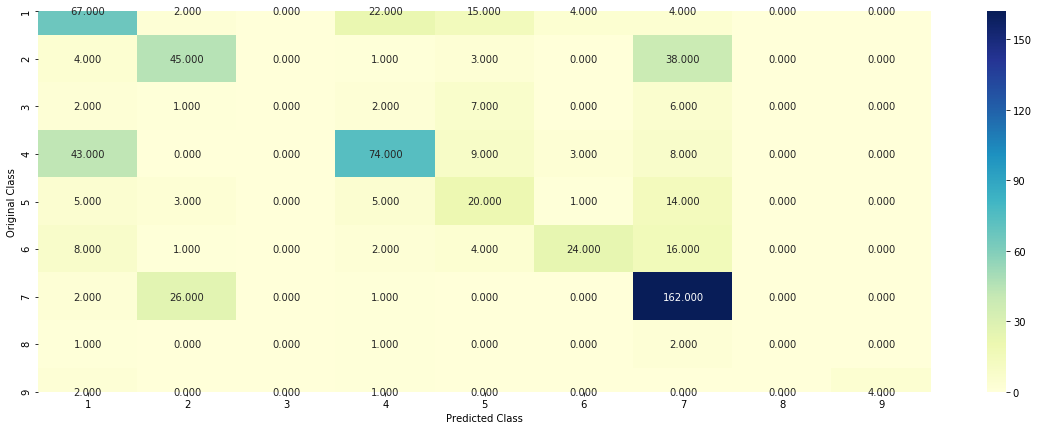

-------------------- Precision matrix (Columm Sum=1) --------------------


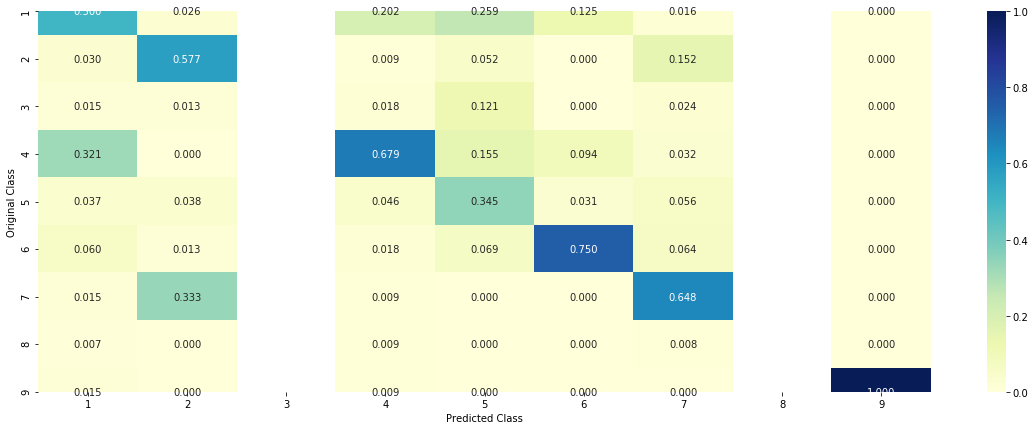

-------------------- Recall matrix (Row sum=1) --------------------


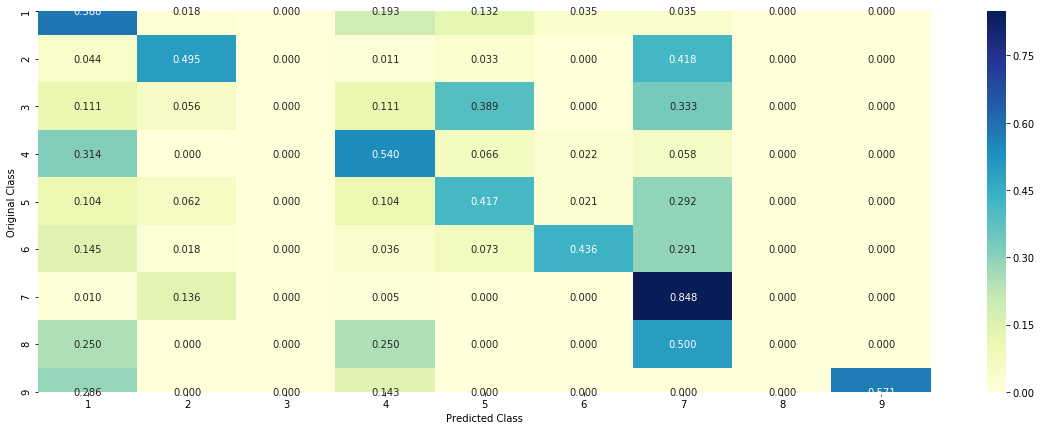

In [239]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_tfidf, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)


print("Percentage of missclassified point :", np.count_nonzero((sclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_tfidf))

<h4>4.6.1.3 Maximum Voting classifier </h4>

Log loss (train) on the VotingClassifier : 0.9238144643305543
Log loss (CV) on the VotingClassifier : 1.1434221163341562
Log loss (test) on the VotingClassifier : 1.2536924946410848
Percentage of missclassified point : 0.3969924812030075
-------------------- Confusion matrix --------------------


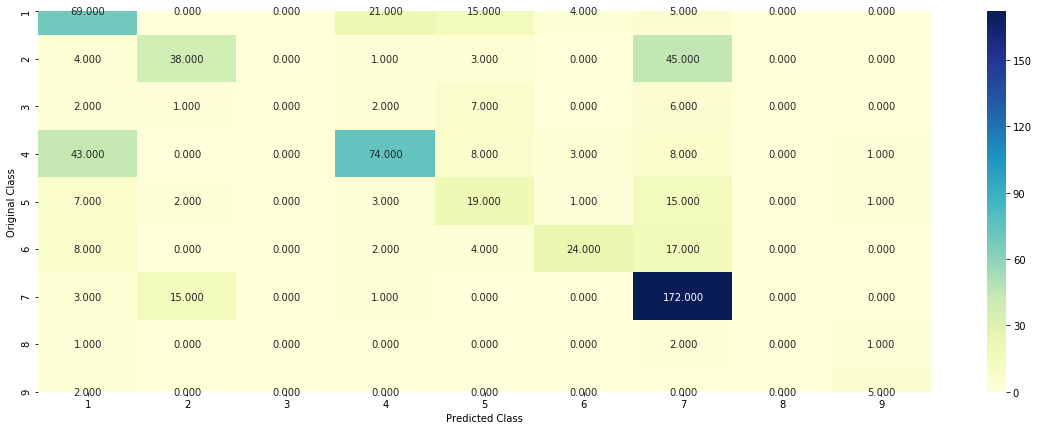

-------------------- Precision matrix (Columm Sum=1) --------------------


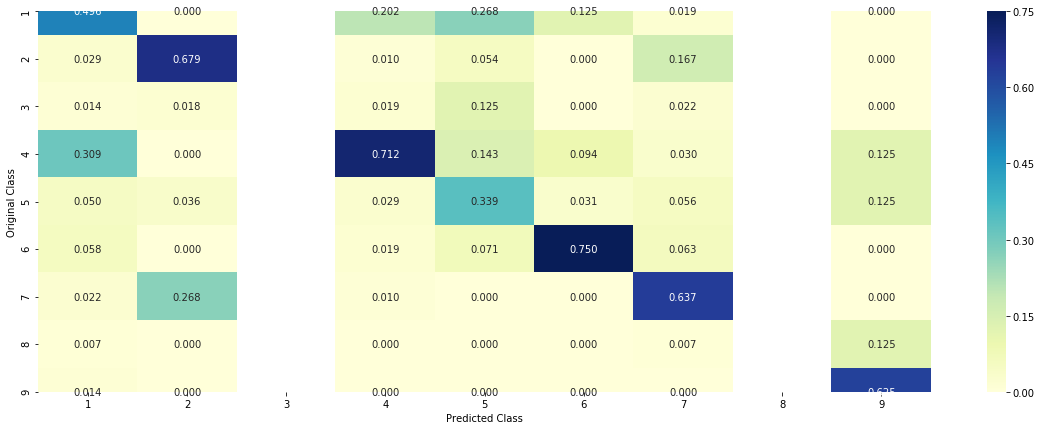

-------------------- Recall matrix (Row sum=1) --------------------


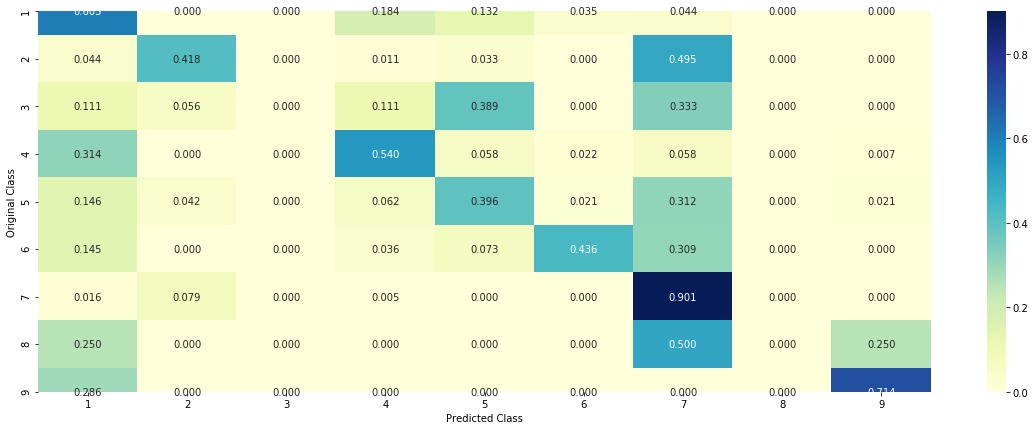

In [240]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_tfidf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidf)))
print("Percentage of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidf))